## Setup - imports, time, parameters, size function

In [1]:
runno = '7486'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

662732

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

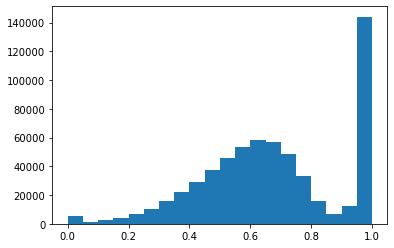

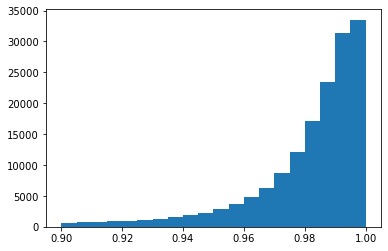

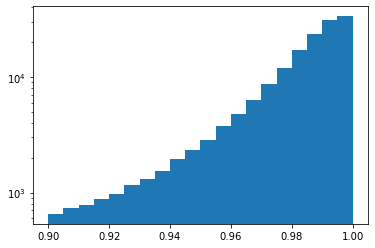

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

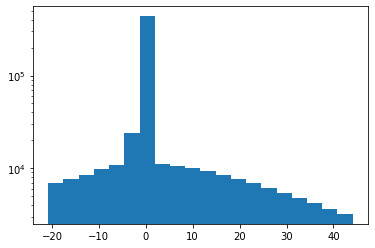

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

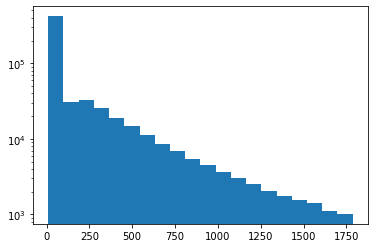

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = -127.3 , 1274.7
Selected percentage = 10.5 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 10.2
200000 / 549170
Est remaining = 7.7
300000 / 549170
Est remaining = 5.4
400000 / 549170
Est remaining = 3.2
500000 / 549170
Est remaining = 1.1


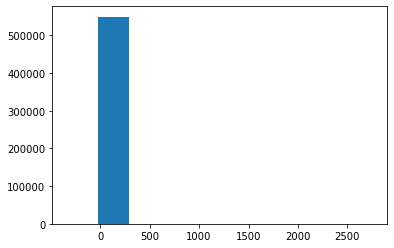

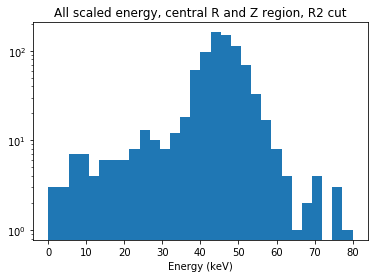

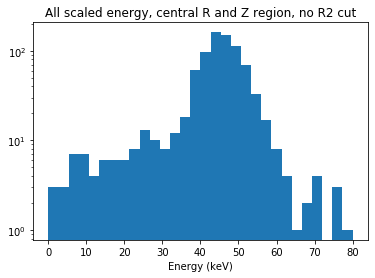

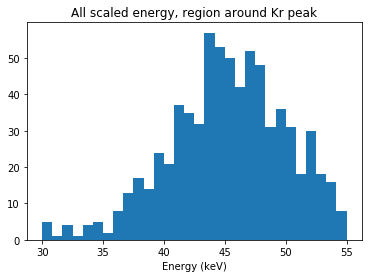

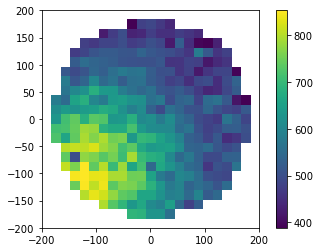

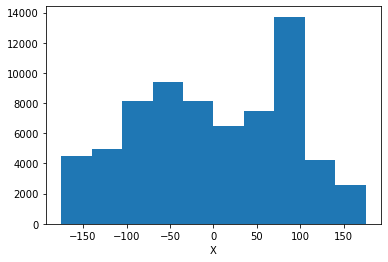

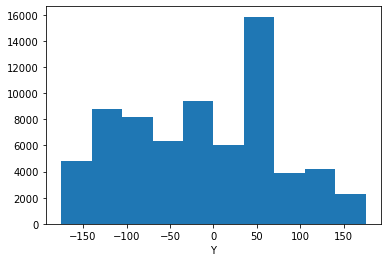

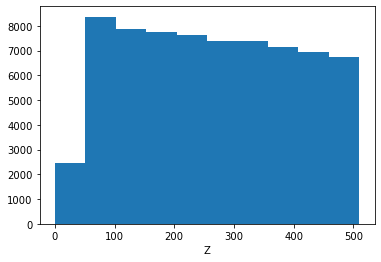

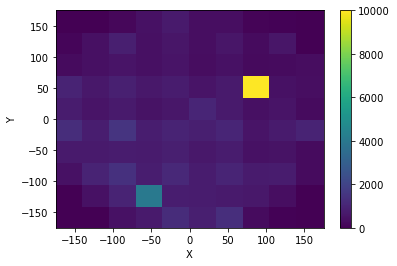

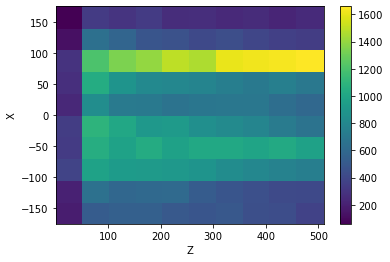

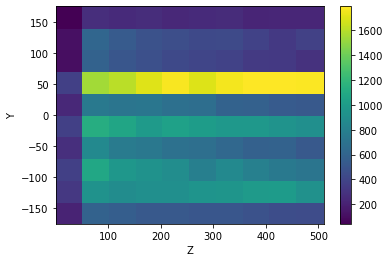

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = -269.9 , 1294.3
Selected percentage = 11.4 \%


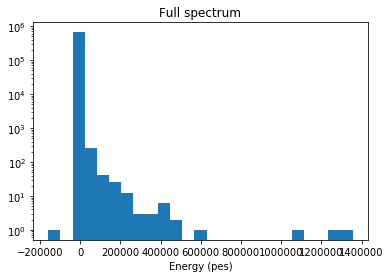

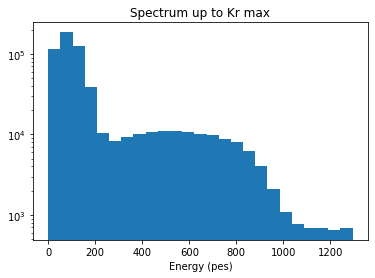

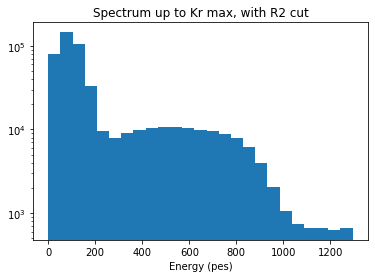

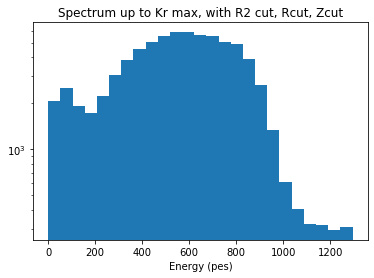

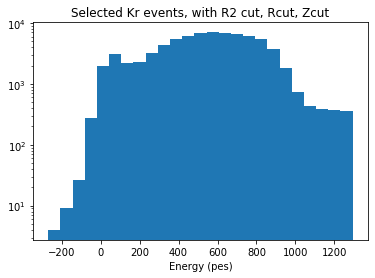

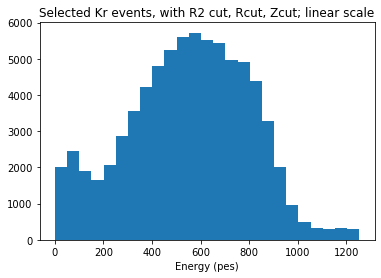

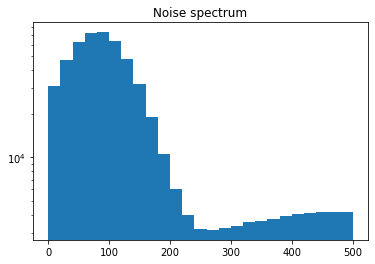

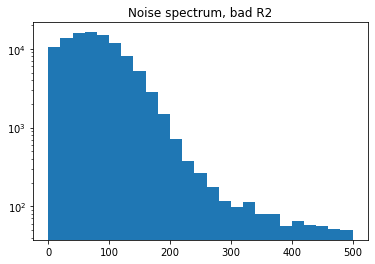

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


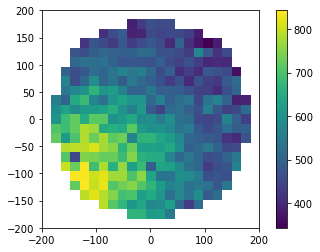

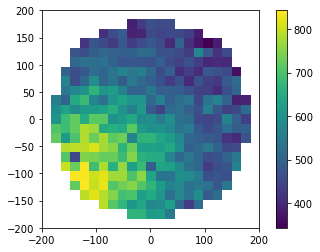

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 10.8
200000 / 549170
Est remaining = 9.0
300000 / 549170
Est remaining = 6.2
400000 / 549170
Est remaining = 3.6
500000 / 549170
Est remaining = 1.2


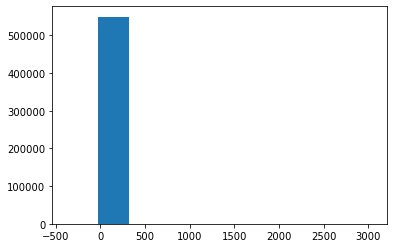

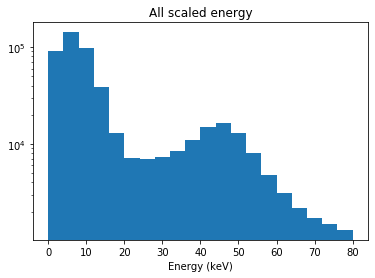

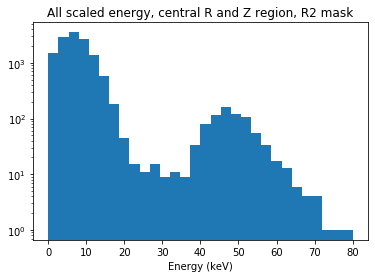

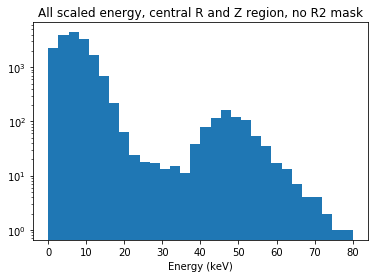

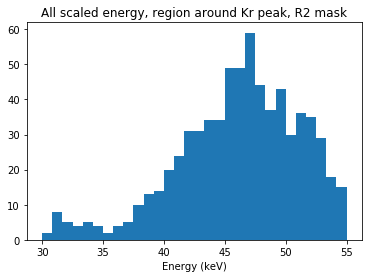

Correcting energies...
0 / 75307


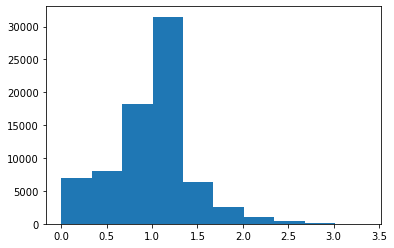

Fit a Gaussian with guess (A0, m0, s0) = (28.0, 1, 0.37792643549790733)


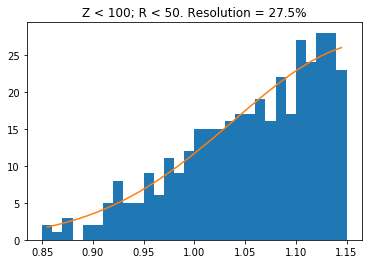

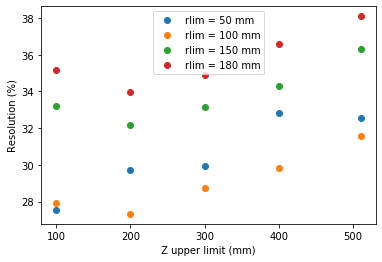

Innermost resolution =  27.53 %
Outermost resolution =  38.1 %
All resolutions: {100050: 27.52842709853249, 100100: 27.923071485560023, 100150: 33.21240570700098, 100180: 35.16735023114382, 200050: 29.729422612679702, 200100: 27.324276178147315, 200150: 32.19869290103034, 200180: 33.94533726584462, 300050: 29.953152862404366, 300100: 28.759358523576804, 300150: 33.166412563907826, 300180: 34.887764501793164, 400050: 32.85186669162117, 400100: 29.822947716086283, 400150: 34.31844256447089, 400180: 36.59721746134478, 510050: 32.54381478360371, 510100: 31.59394880846359, 510150: 36.338838778224655, 510180: 38.10032669821745}

================ CHECKING R2 CUT = 0.5 ================
Peak range = -254.9 , 1292.9
Selected percentage = 11.3 \%


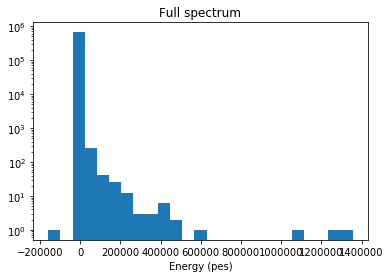

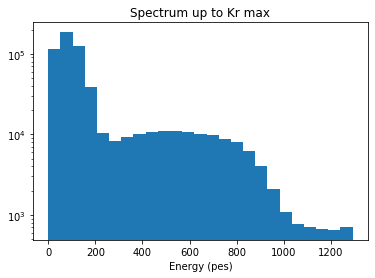

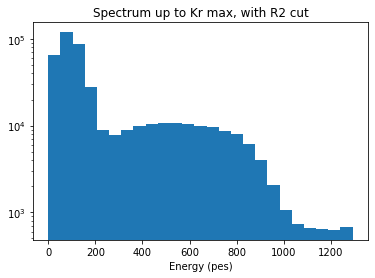

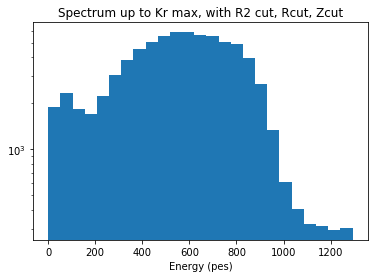

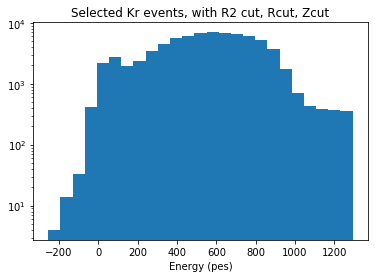

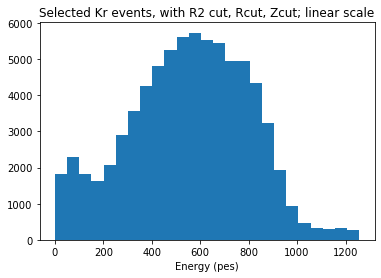

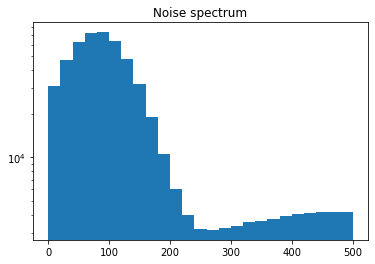

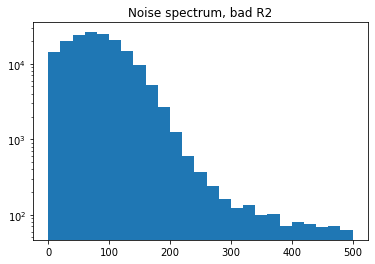

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


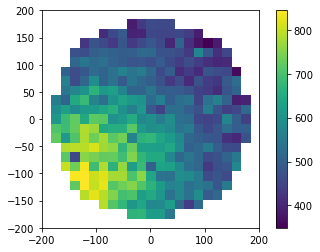

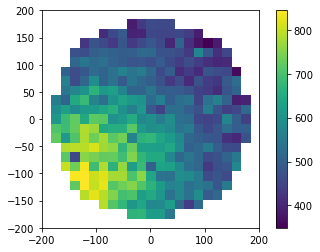

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 11.3
200000 / 549170
Est remaining = 8.2
300000 / 549170
Est remaining = 5.8
400000 / 549170
Est remaining = 3.4
500000 / 549170
Est remaining = 1.2


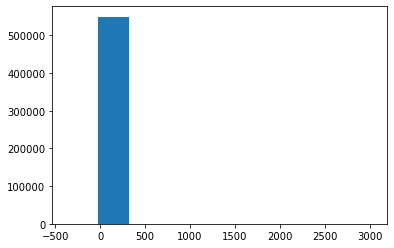

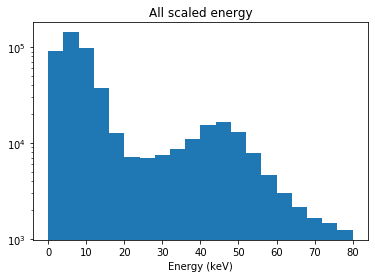

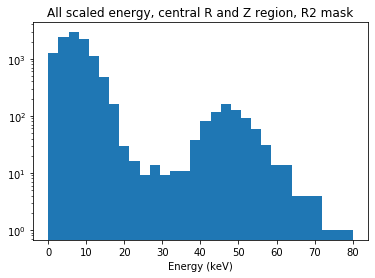

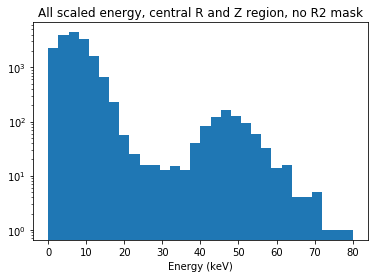

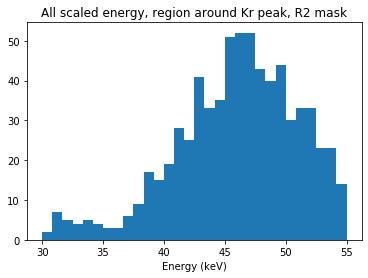

Correcting energies...
0 / 74854


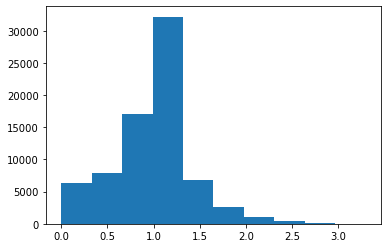

Fit a Gaussian with guess (A0, m0, s0) = (31.0, 1, 0.3731515164360336)


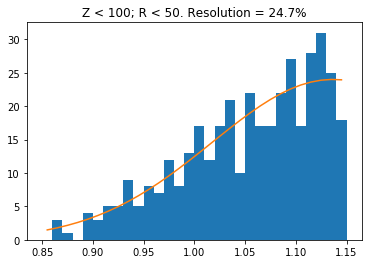

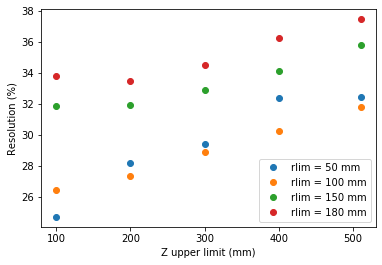

Innermost resolution =  24.72 %
Outermost resolution =  37.46 %
All resolutions: {100050: 24.72051075692459, 100100: 26.48163821323918, 100150: 31.859923487955175, 100180: 33.819095354345784, 200050: 28.197291194194086, 200100: 27.376247356139046, 200150: 31.94350520050524, 200180: 33.4611761052678, 300050: 29.393518935072496, 300100: 28.88379561616639, 300150: 32.88897261356734, 300180: 34.51413005636027, 400050: 32.35793491321764, 400100: 30.26364055748161, 400150: 34.11992553694358, 400180: 36.27146568781269, 510050: 32.43821834199394, 510100: 31.80716324633076, 510150: 35.78677866612749, 510180: 37.45954709837458}

================ CHECKING R2 CUT = 0.6 ================
Peak range = -231.0 , 1290.7
Selected percentage = 11.2 \%


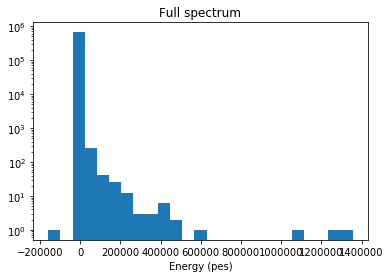

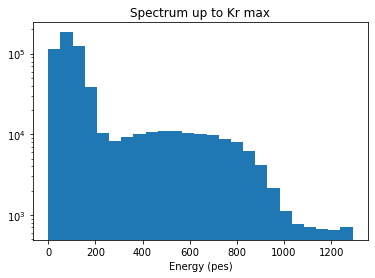

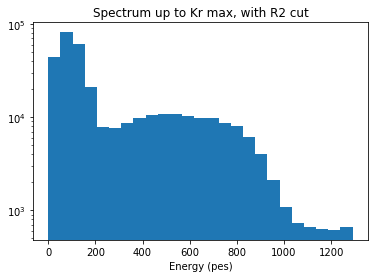

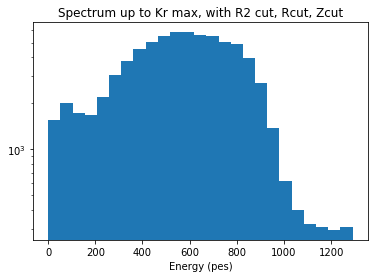

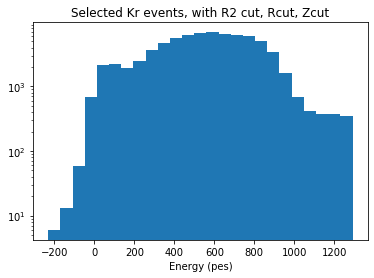

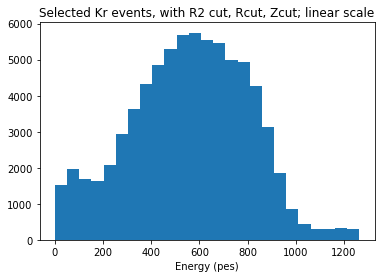

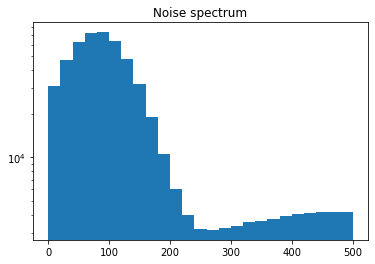

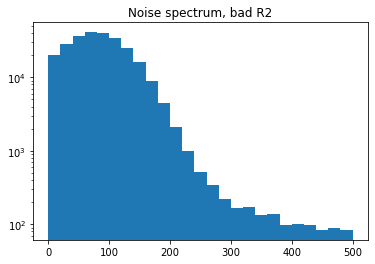

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


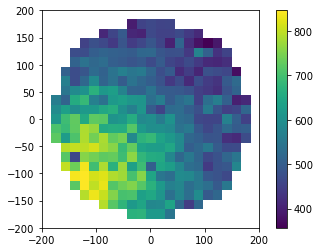

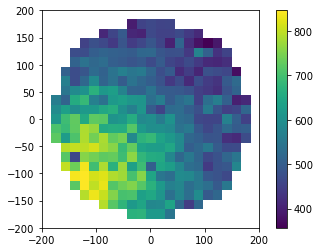

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 11.6
200000 / 549170
Est remaining = 9.2
300000 / 549170
Est remaining = 6.8
400000 / 549170
Est remaining = 4.0
500000 / 549170
Est remaining = 1.3


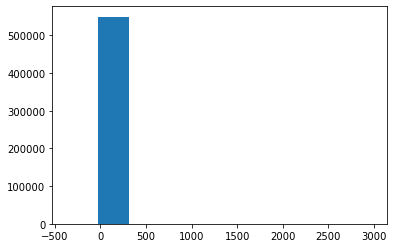

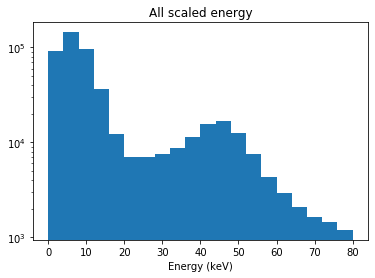

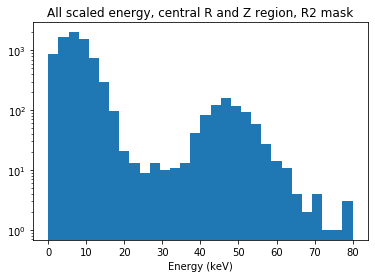

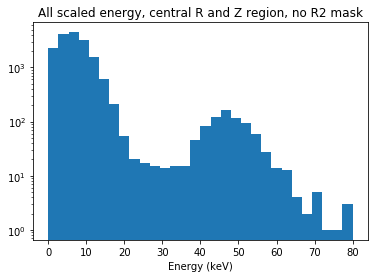

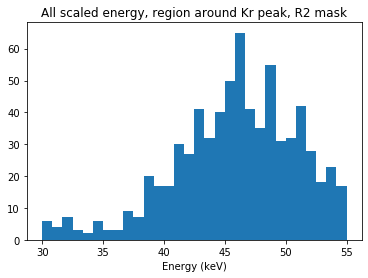

Correcting energies...
0 / 74078


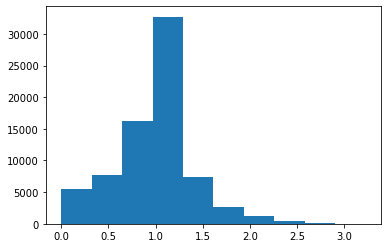

Fit a Gaussian with guess (A0, m0, s0) = (34.0, 1, 0.35155706397726505)


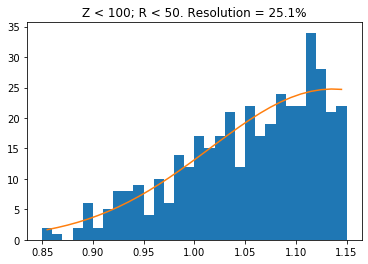

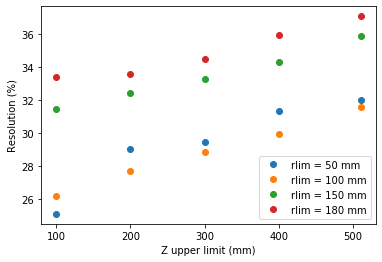

Innermost resolution =  25.1 %
Outermost resolution =  37.07 %
All resolutions: {100050: 25.096696089165434, 100100: 26.20382095230267, 100150: 31.467753664433168, 100180: 33.39225809593138, 200050: 29.016331964456572, 200100: 27.67392829490101, 200150: 32.43456099792783, 200180: 33.57272170881671, 300050: 29.446639397669962, 300100: 28.83342690362354, 300150: 33.27147979846281, 300180: 34.48766708359081, 400050: 31.349995178535398, 400100: 29.946708096525782, 400150: 34.29200904444092, 400180: 35.92105685799475, 510050: 31.99422632423158, 510100: 31.567141565628067, 510150: 35.87709800037016, 510180: 37.07364649077619}

================ CHECKING R2 CUT = 0.7 ================
Peak range = -192.0 , 1286.9
Selected percentage = 11.0 \%


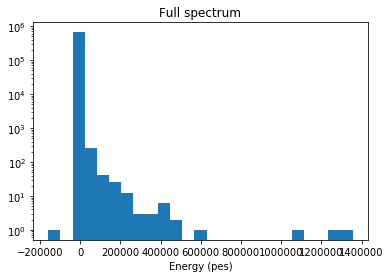

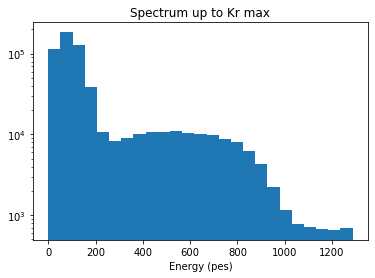

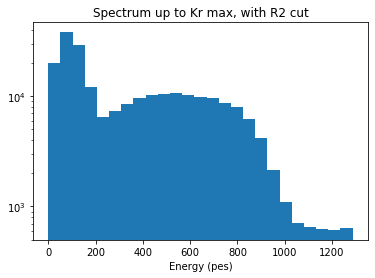

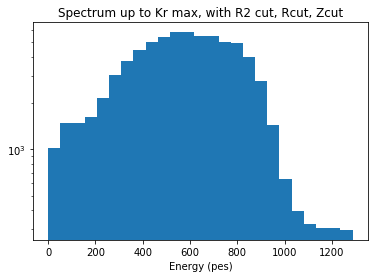

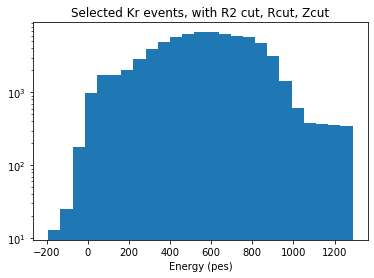

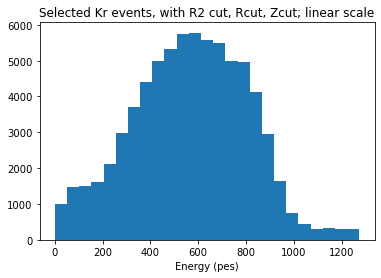

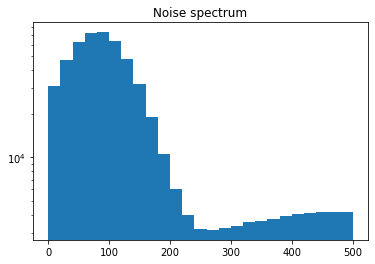

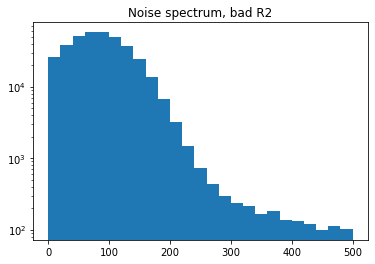

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


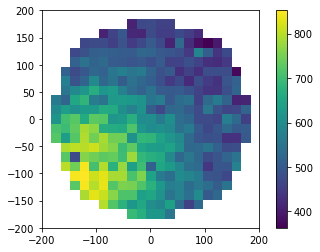

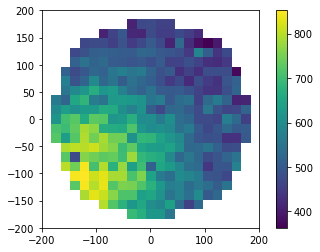

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 11.9
200000 / 549170
Est remaining = 10.3
300000 / 549170
Est remaining = 7.3
400000 / 549170
Est remaining = 4.3
500000 / 549170
Est remaining = 1.4


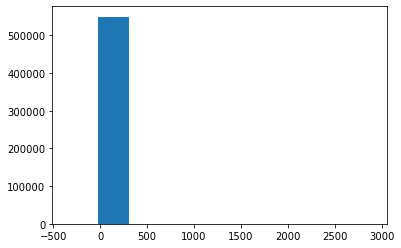

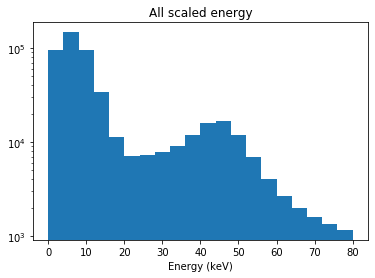

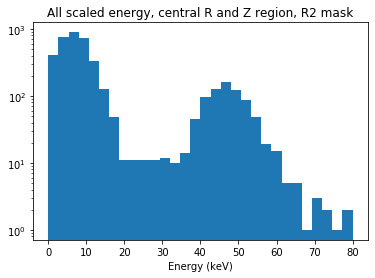

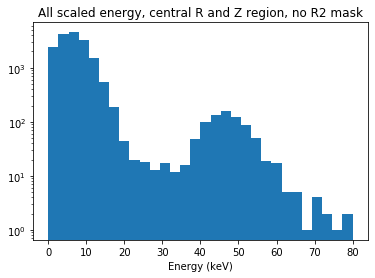

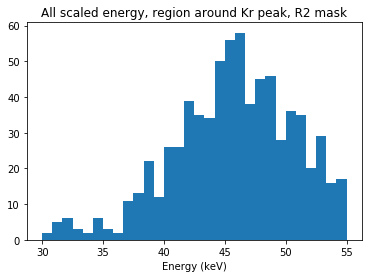

Correcting energies...
0 / 72778


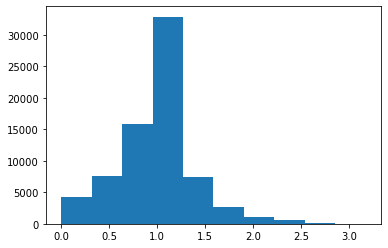

Fit a Gaussian with guess (A0, m0, s0) = (36.0, 1, 0.3198390684467019)


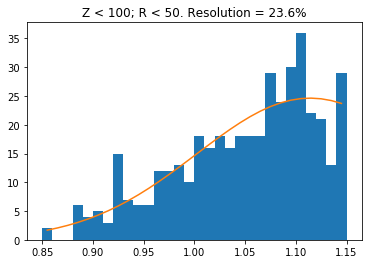

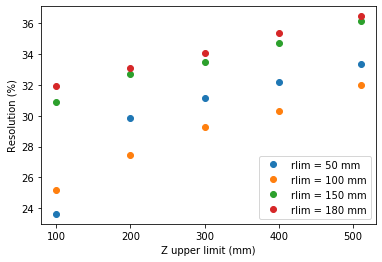

Innermost resolution =  23.63 %
Outermost resolution =  36.45 %
All resolutions: {100050: 23.6325327850106, 100100: 25.20189927818615, 100150: 30.88765690946531, 100180: 31.935486860311972, 200050: 29.840989671057248, 200100: 27.434008622994966, 200150: 32.71176337798766, 200180: 33.07786172796992, 300050: 31.121855885440098, 300100: 29.2405484390953, 300150: 33.46218093390906, 300180: 34.043137297720584, 400050: 32.18717256257067, 400100: 30.329395400994954, 400150: 34.70406808969294, 400180: 35.39023257805736, 510050: 33.32465537290575, 510100: 31.988632655054083, 510150: 36.16471170367635, 510180: 36.44714652902294}

================ CHECKING R2 CUT = 0.8 ================
Peak range = -153.7 , 1281.3
Selected percentage = 10.7 \%


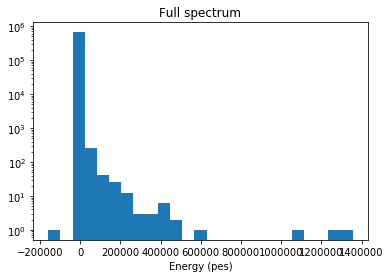

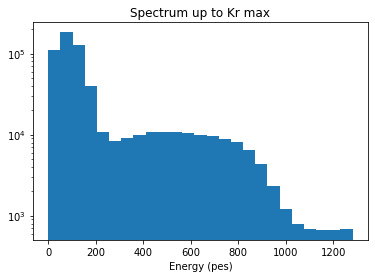

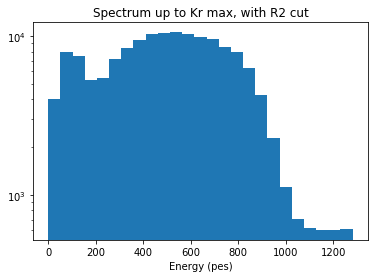

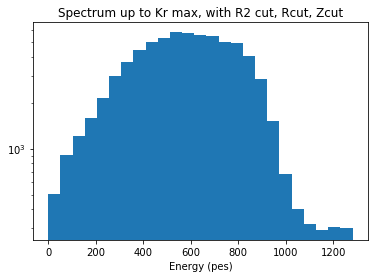

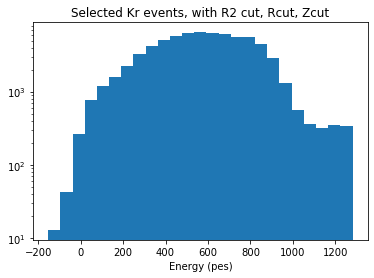

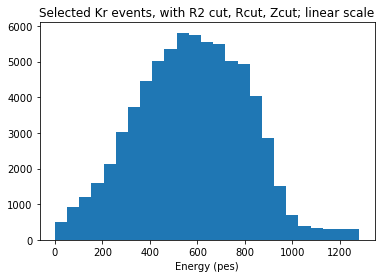

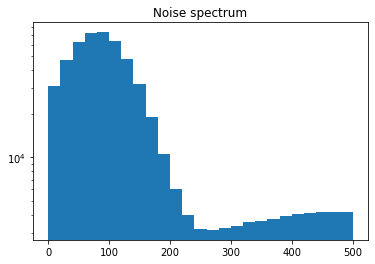

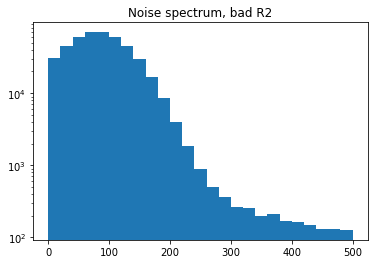

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


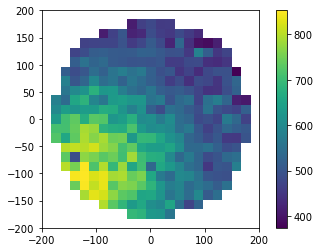

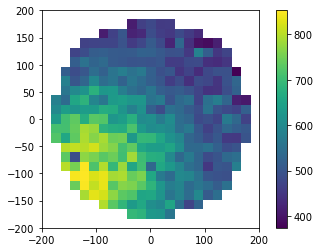

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 20.2
200000 / 549170
Est remaining = 14.8
300000 / 549170
Est remaining = 10.3
400000 / 549170
Est remaining = 6.1
500000 / 549170
Est remaining = 2.0


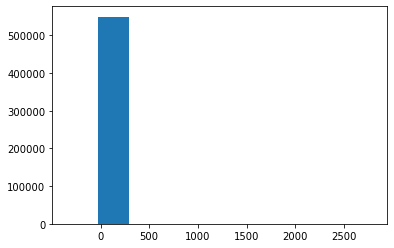

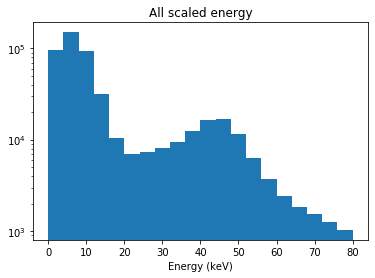

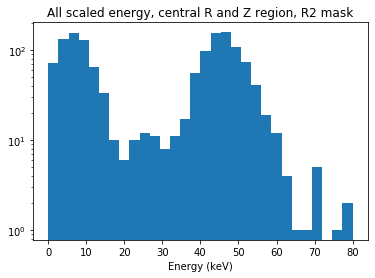

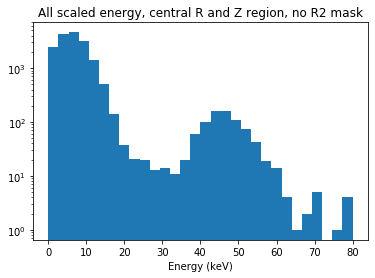

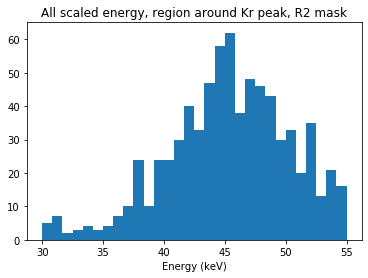

Correcting energies...
0 / 71160


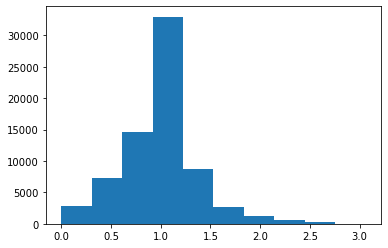

Fit a Gaussian with guess (A0, m0, s0) = (34.0, 1, 0.27996020978797087)


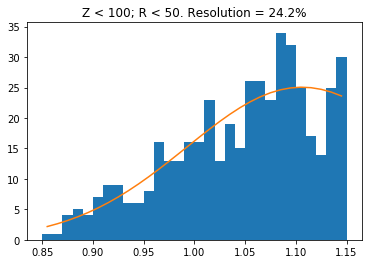

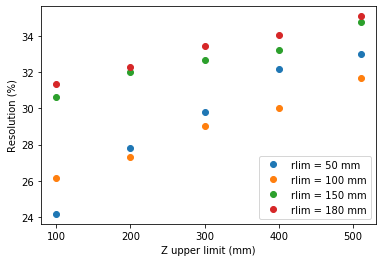

Innermost resolution =  24.17 %
Outermost resolution =  35.09 %
All resolutions: {100050: 24.173141011673497, 100100: 26.15966358367497, 100150: 30.62322574324132, 100180: 31.367174337357298, 200050: 27.796114958241823, 200100: 27.3041315764289, 200150: 32.00623233688624, 200180: 32.293189895992306, 300050: 29.792774078531647, 300100: 29.034332162628903, 300150: 32.65868169908088, 300180: 33.43604417954861, 400050: 32.172764903058784, 400100: 30.018446858310828, 400150: 33.23661874923624, 400180: 34.02354454196453, 510050: 32.99110387917172, 510100: 31.65809942353879, 510150: 34.745873340777685, 510180: 35.086178097838726}

================ CHECKING R2 CUT = 0.9 ================
Peak range = -124.6 , 1274.1
Selected percentage = 10.5 \%


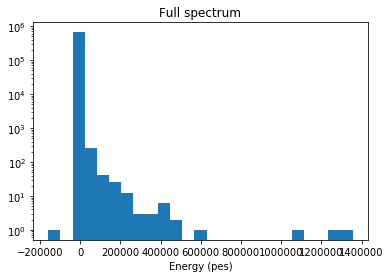

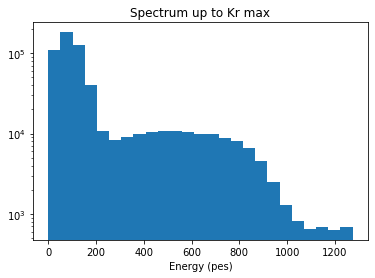

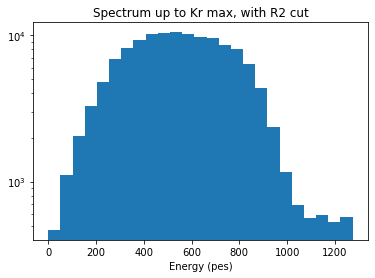

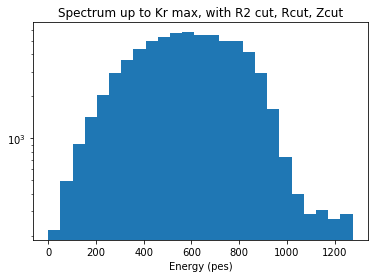

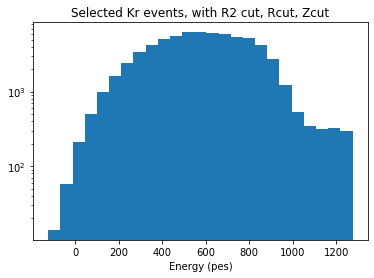

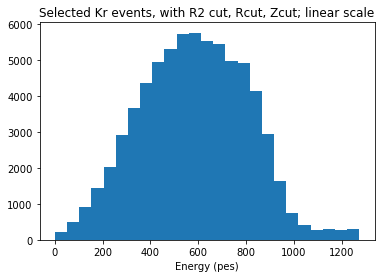

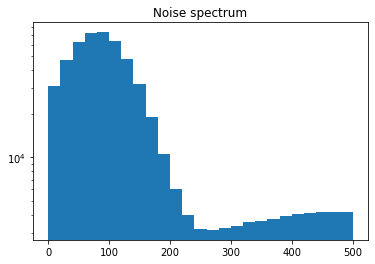

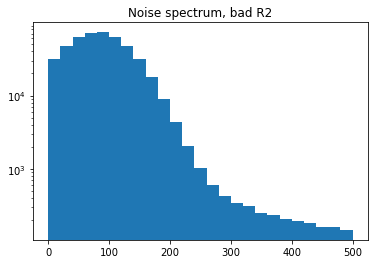

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


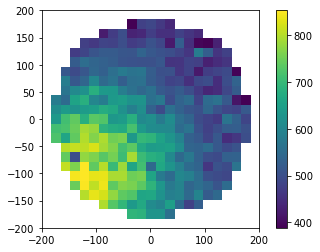

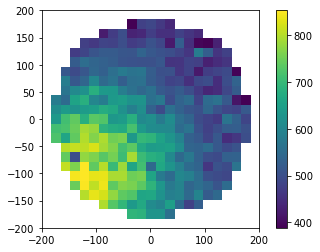

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 18.7
200000 / 549170
Est remaining = 13.9
300000 / 549170
Est remaining = 9.6
400000 / 549170
Est remaining = 5.6
500000 / 549170
Est remaining = 1.8


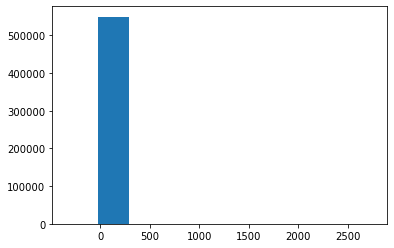

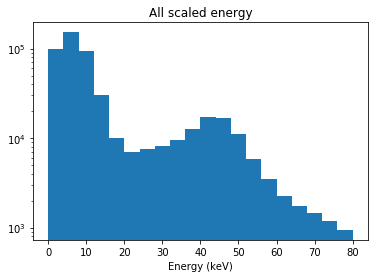

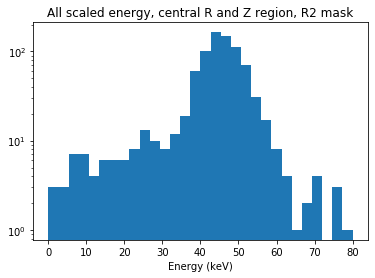

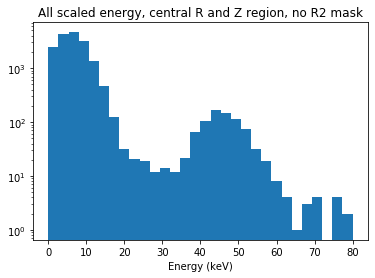

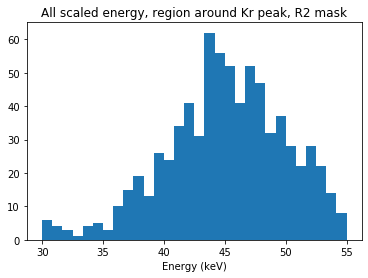

Correcting energies...
0 / 69529


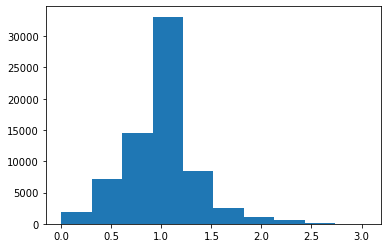

Fit a Gaussian with guess (A0, m0, s0) = (35.0, 1, 0.24206718066436092)


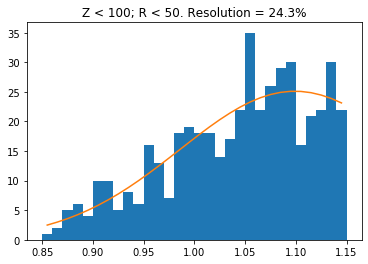

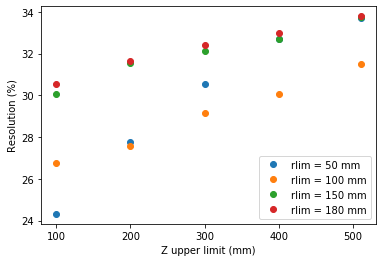

Innermost resolution =  24.32 %
Outermost resolution =  33.79 %
All resolutions: {100050: 24.321522957097216, 100100: 26.74569594149268, 100150: 30.04307683475492, 100180: 30.541853332370277, 200050: 27.74281170332689, 200100: 27.592005690549875, 200150: 31.53088857505414, 200180: 31.65505072997932, 300050: 30.53657341080637, 300100: 29.140078841983883, 300150: 32.12091555156085, 300180: 32.40116340880371, 400050: 32.719094011017944, 400100: 30.067625783004434, 400150: 32.71806487656898, 400180: 32.9753867837826, 510050: 33.68310086456658, 510100: 31.494489209748213, 510150: 33.75812082335451, 510180: 33.789779828398196}

================ CHECKING R2 CUT = 0.92 ================
Peak range = -113.8 , 1271.4
Selected percentage = 10.4 \%


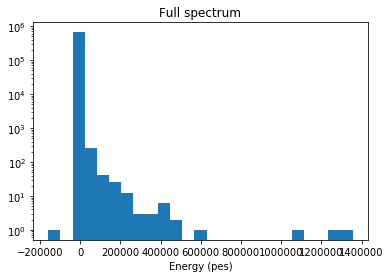

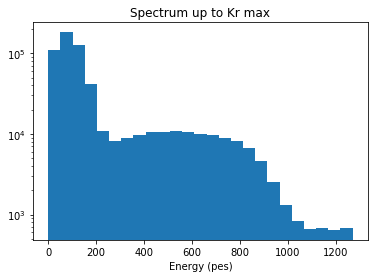

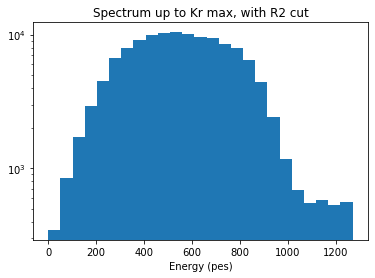

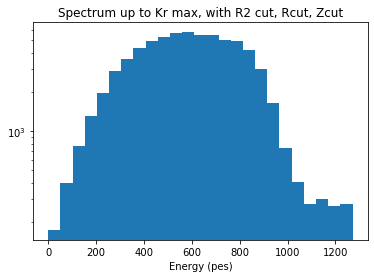

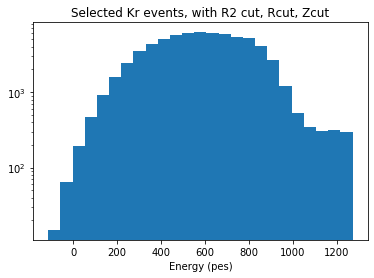

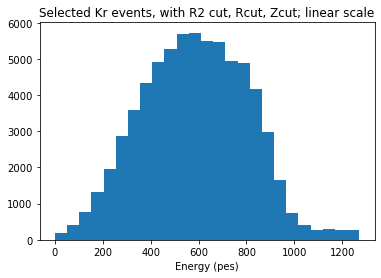

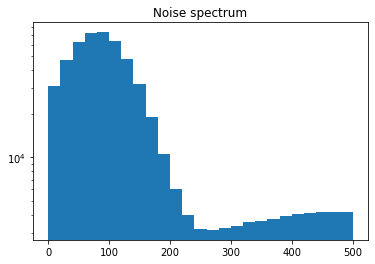

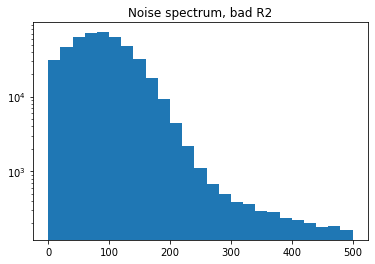

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


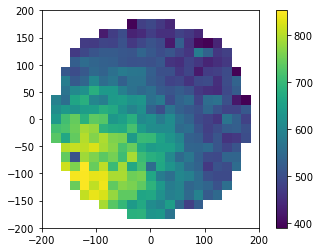

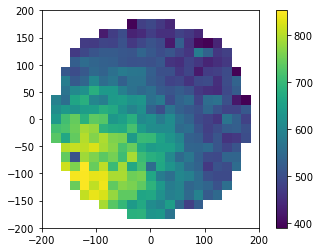

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 16.6
200000 / 549170
Est remaining = 13.0
300000 / 549170
Est remaining = 9.3
400000 / 549170
Est remaining = 5.7
500000 / 549170
Est remaining = 1.9


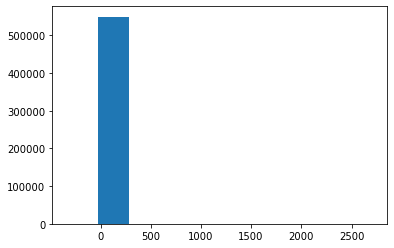

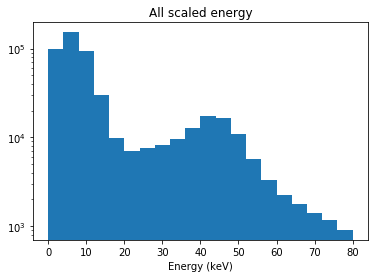

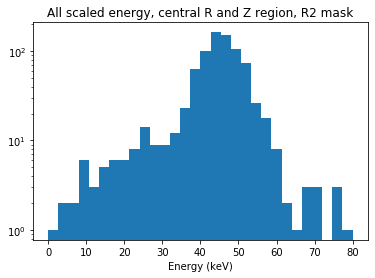

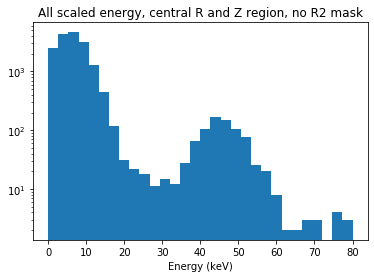

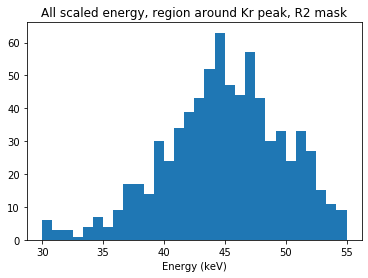

Correcting energies...
0 / 68911


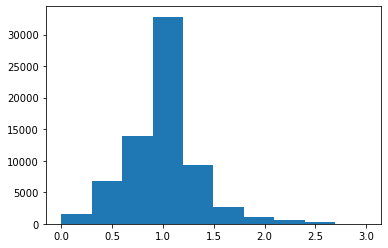

Fit a Gaussian with guess (A0, m0, s0) = (32.0, 1, 0.2321708907288845)


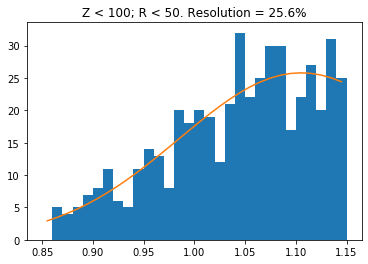

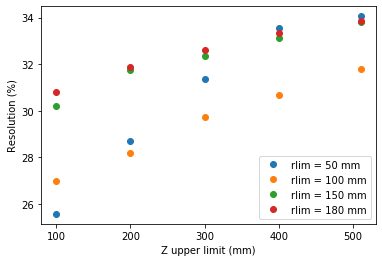

Innermost resolution =  25.58 %
Outermost resolution =  33.86 %
All resolutions: {100050: 25.577212883161003, 100100: 26.99850450073171, 100150: 30.211682635436574, 100180: 30.820261673300124, 200050: 28.697378292123663, 200100: 28.206091025376576, 200150: 31.77206206743494, 200180: 31.875326110642252, 300050: 31.348816500000193, 300100: 29.717651386790003, 300150: 32.34484970370174, 300180: 32.628787554940246, 400050: 33.5731562648364, 400100: 30.693273029697668, 400150: 33.12592238821291, 400180: 33.34881288514185, 510050: 34.05893435837658, 510100: 31.792413727423092, 510150: 33.81489690969745, 510180: 33.86017025480457}

================ CHECKING R2 CUT = 0.94 ================
Peak range = -94.1 , 1266.9
Selected percentage = 10.2 \%


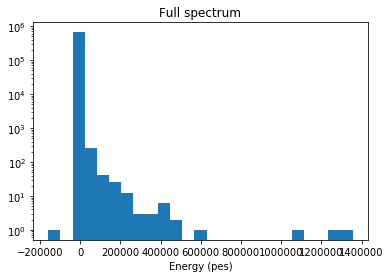

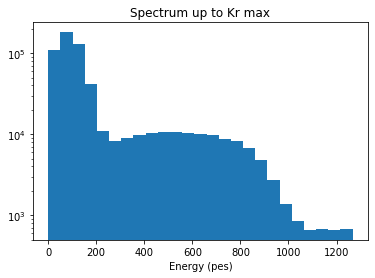

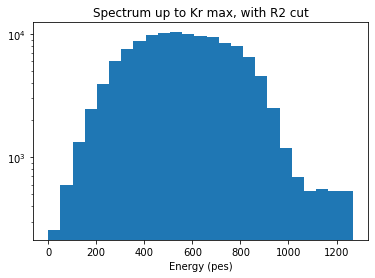

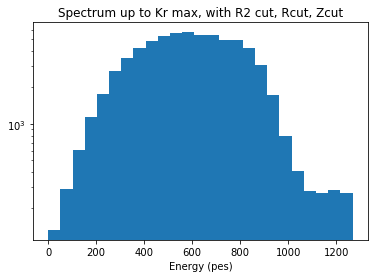

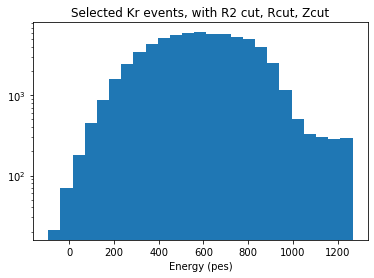

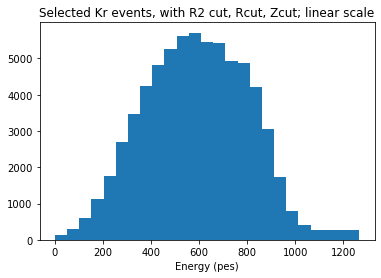

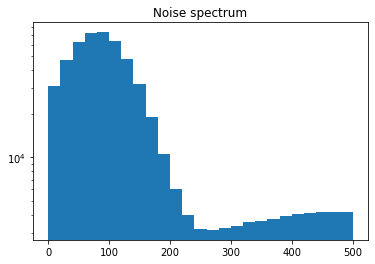

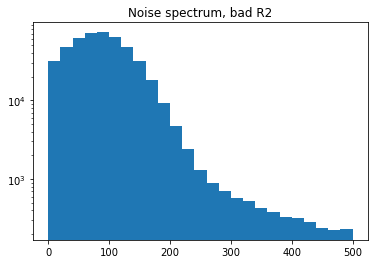

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


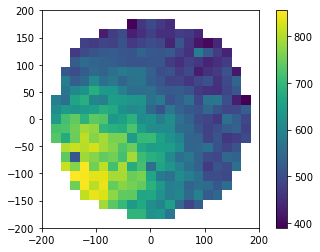

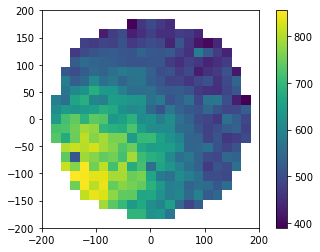

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 18.6
200000 / 549170
Est remaining = 13.5
300000 / 549170
Est remaining = 9.6
400000 / 549170
Est remaining = 6.0
500000 / 549170
Est remaining = 2.2


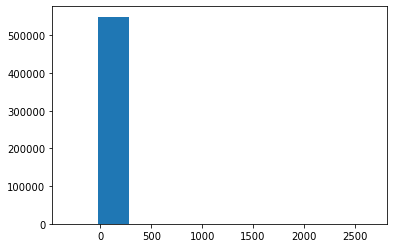

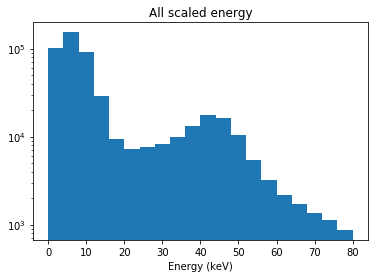

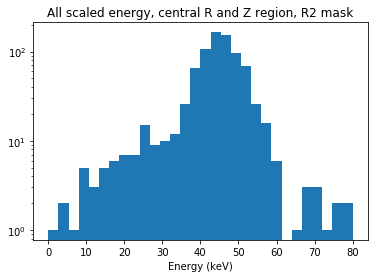

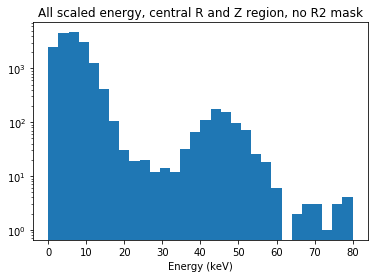

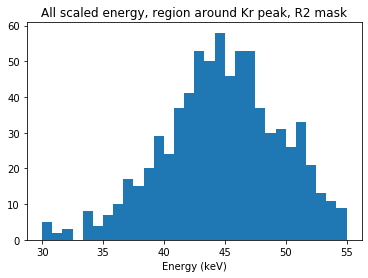

Correcting energies...
0 / 67768


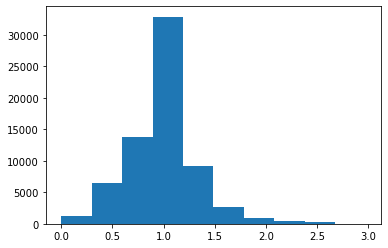

Fit a Gaussian with guess (A0, m0, s0) = (34.0, 1, 0.22782493968904077)


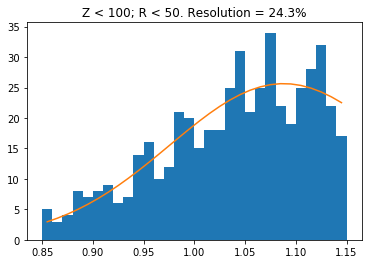

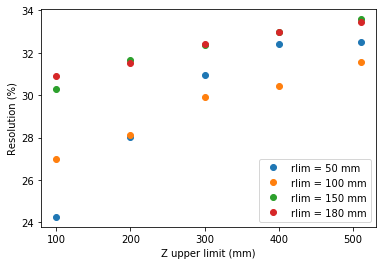

Innermost resolution =  24.26 %
Outermost resolution =  33.46 %
All resolutions: {100050: 24.258468705252078, 100100: 27.0031869677826, 100150: 30.271248511465615, 100180: 30.928406482515648, 200050: 28.027761672509378, 200100: 28.12632586688609, 200150: 31.657161646250493, 200180: 31.540257619345166, 300050: 30.933216330838817, 300100: 29.91777563023031, 300150: 32.36584113727704, 300180: 32.4233982393234, 400050: 32.410940321229575, 400100: 30.44677526857066, 400150: 32.960704388137714, 400180: 32.98383281786745, 510050: 32.52745542752371, 510100: 31.562633646149504, 510150: 33.585726445215556, 510180: 33.463960380909256}

================ CHECKING R2 CUT = 0.96 ================
Peak range = -62.3 , 1260.7
Selected percentage = 9.8 \%


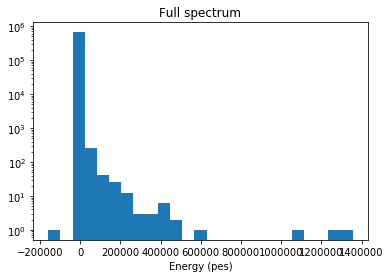

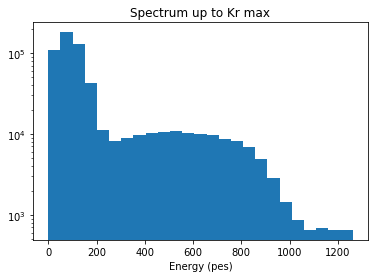

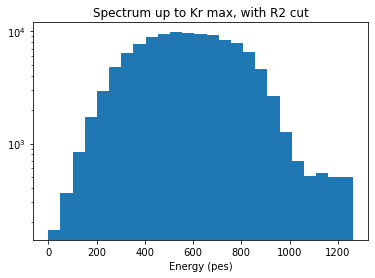

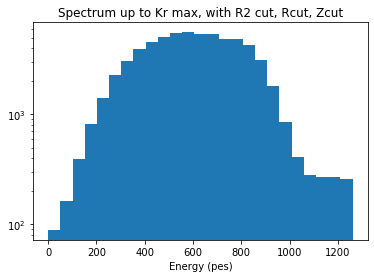

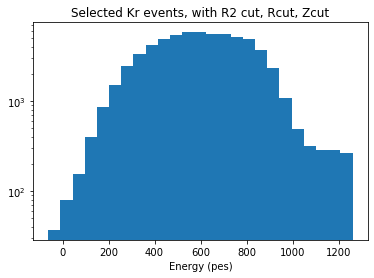

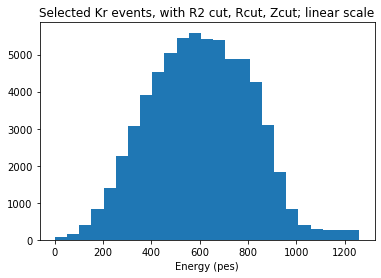

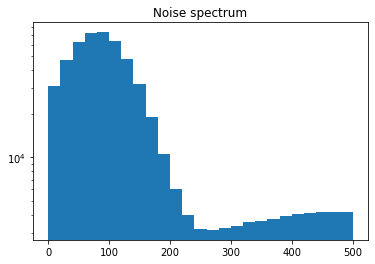

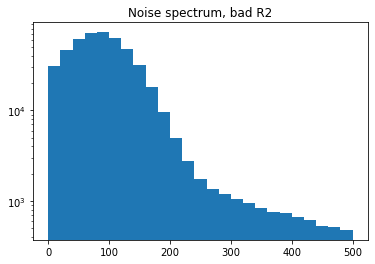

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


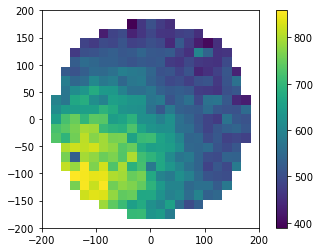

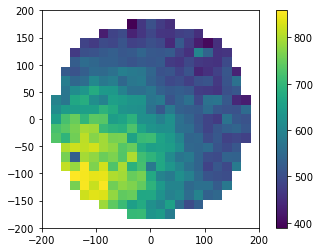

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 36.2
200000 / 549170
Est remaining = 22.3
300000 / 549170
Est remaining = 15.6
400000 / 549170
Est remaining = 9.4
500000 / 549170
Est remaining = 3.1


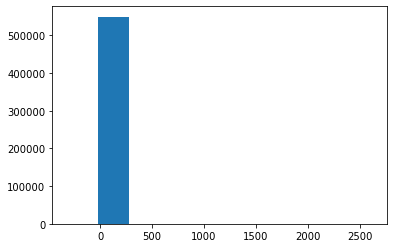

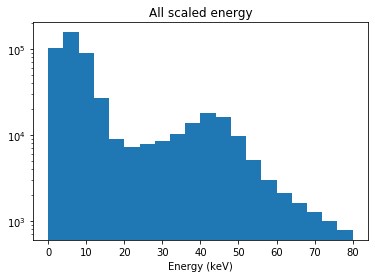

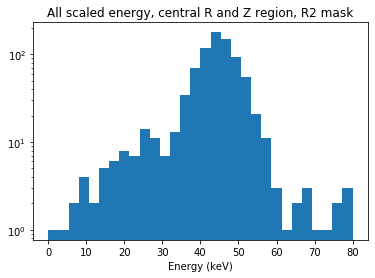

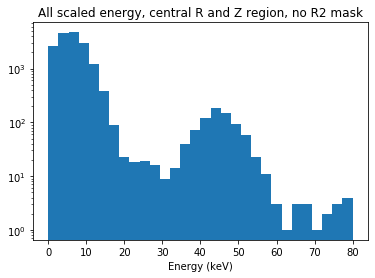

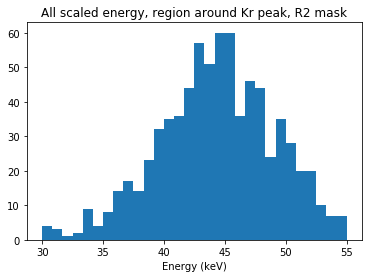

Correcting energies...
0 / 64794


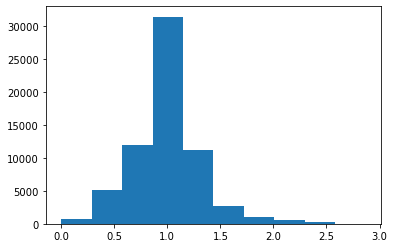

Fit a Gaussian with guess (A0, m0, s0) = (33.0, 1, 0.22016824155483208)


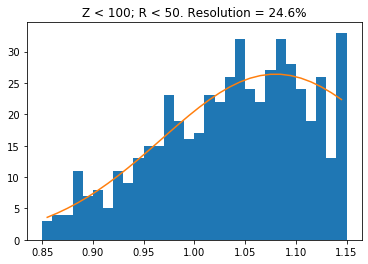

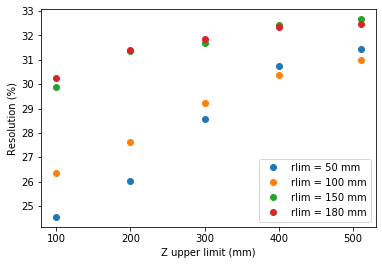

Innermost resolution =  24.55 %
Outermost resolution =  32.49 %
All resolutions: {100050: 24.550059009870896, 100100: 26.351702962934503, 100150: 29.880749120286247, 100180: 30.263057625592168, 200050: 26.01209163566327, 200100: 27.628965140565136, 200150: 31.355304957895918, 200180: 31.39710679829813, 300050: 28.575292994504263, 300100: 29.206893012829955, 300150: 31.682627261274007, 300180: 31.8561032581559, 400050: 30.754283206270593, 400100: 30.391575984403545, 400150: 32.41653342727472, 400180: 32.3347698305579, 510050: 31.436143145140544, 510100: 30.977053866061198, 510150: 32.66496207864432, 510180: 32.48867687194581}

================ CHECKING R2 CUT = 0.98 ================
Peak range = -1.9 , 1253.4
Selected percentage = 8.0 \%


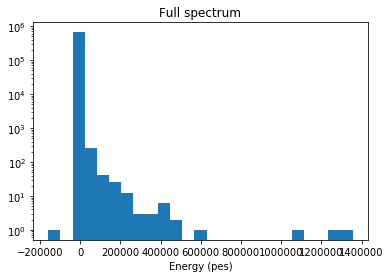

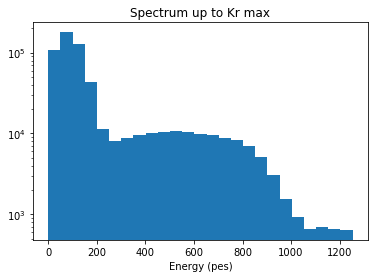

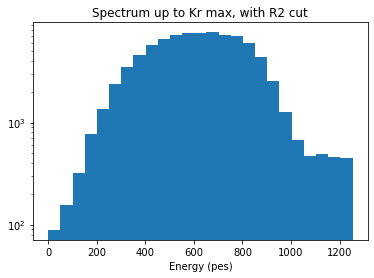

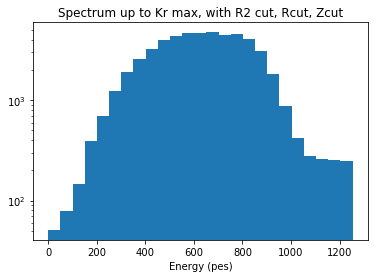

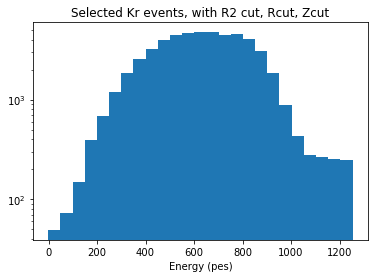

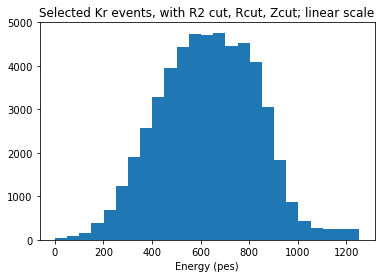

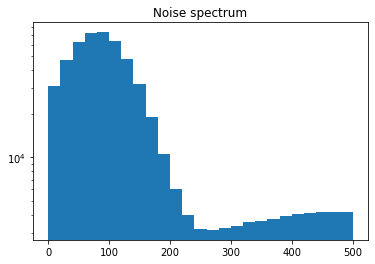

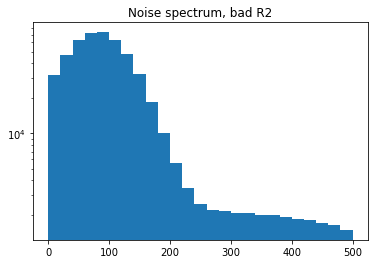

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


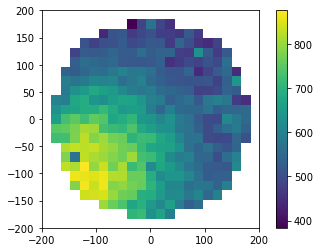

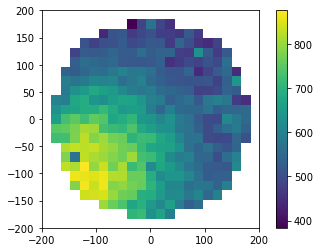

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 23.6
200000 / 549170
Est remaining = 19.4
300000 / 549170
Est remaining = 13.7
400000 / 549170
Est remaining = 7.8
500000 / 549170
Est remaining = 2.5


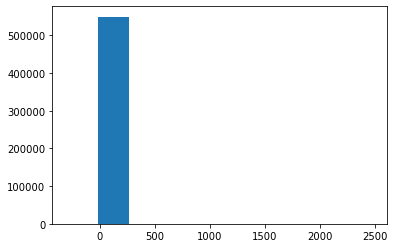

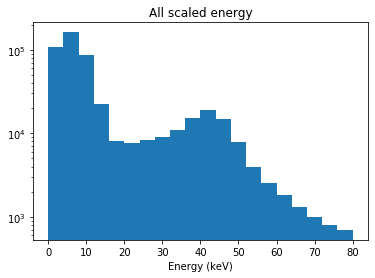

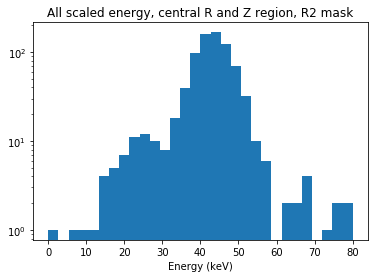

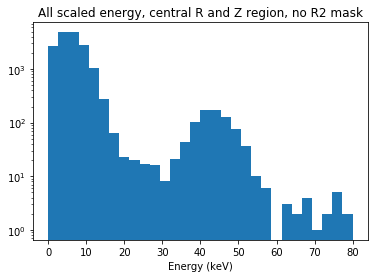

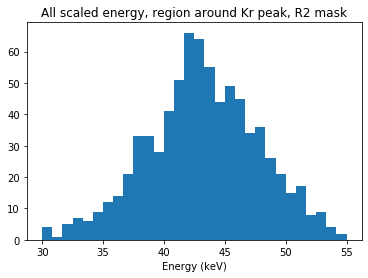

Correcting energies...
0 / 53245


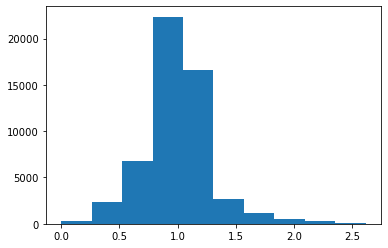

Fit a Gaussian with guess (A0, m0, s0) = (32.0, 1, 0.1973647018093817)


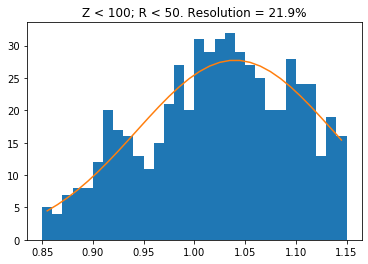

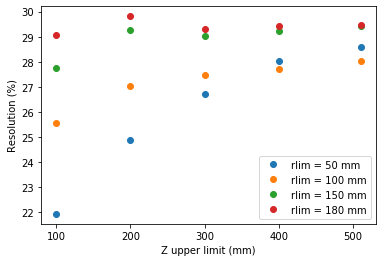

Innermost resolution =  21.93 %
Outermost resolution =  29.47 %
All resolutions: {100050: 21.93165903905208, 100100: 25.57592511308731, 100150: 27.744501094412946, 100180: 29.085881449582185, 200050: 24.873729722091962, 200100: 27.02675717045085, 200150: 29.258299091796925, 200180: 29.81416216577983, 300050: 26.708030263755635, 300100: 27.490729175905003, 300150: 29.03062457938173, 300180: 29.31362052679866, 400050: 28.01102579438608, 400100: 27.72358686261961, 400150: 29.241410534701902, 400180: 29.416359336130892, 510050: 28.605966444889322, 510100: 28.010808298564452, 510150: 29.439576104428156, 510180: 29.46829419509243}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 41.5 , 1269.0
Selected percentage = 5.1 \%


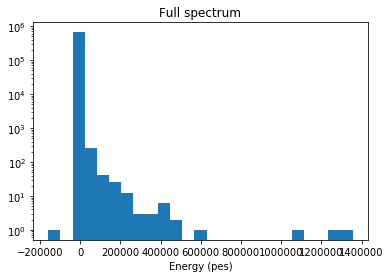

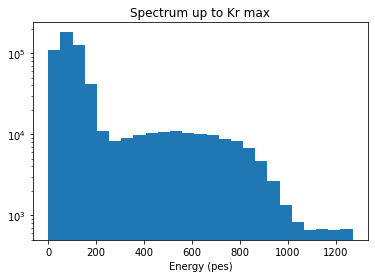

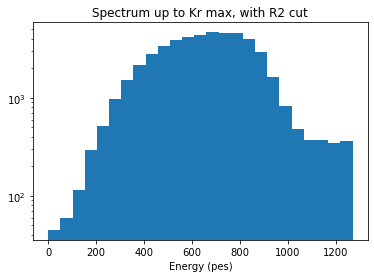

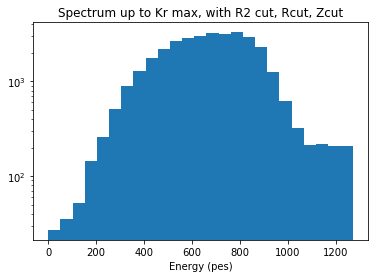

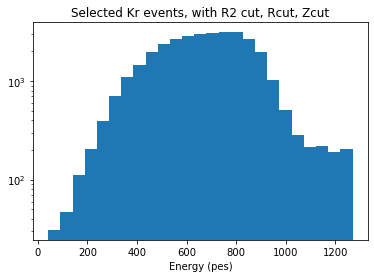

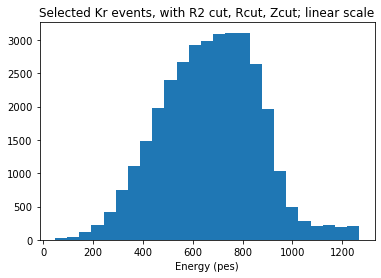

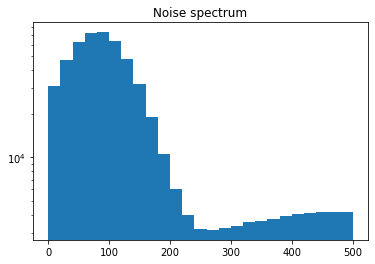

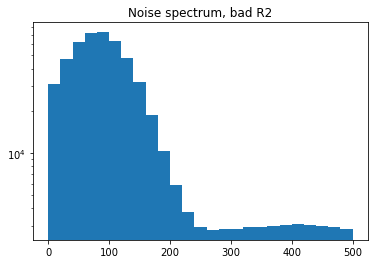

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


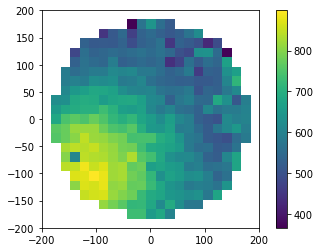

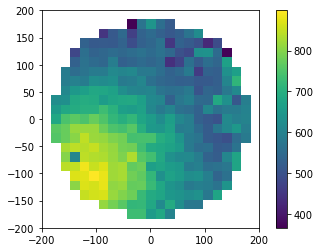

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 18.0
200000 / 549170
Est remaining = 13.7
300000 / 549170
Est remaining = 9.6
400000 / 549170
Est remaining = 5.8
500000 / 549170
Est remaining = 1.9


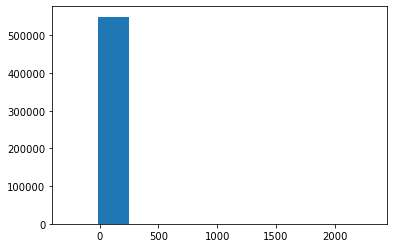

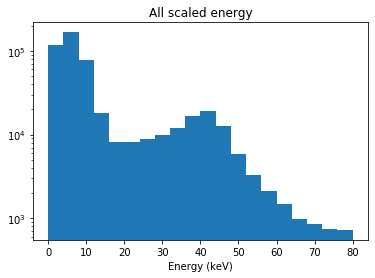

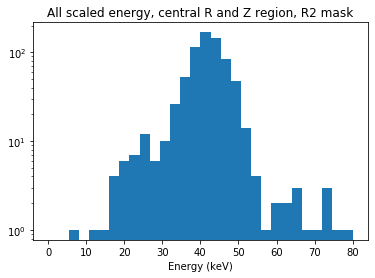

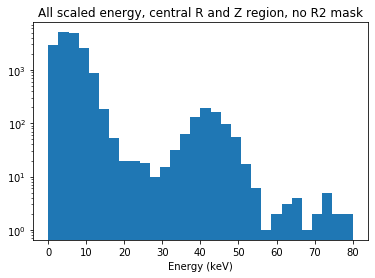

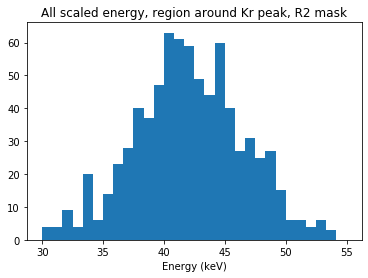

Correcting energies...
0 / 33669


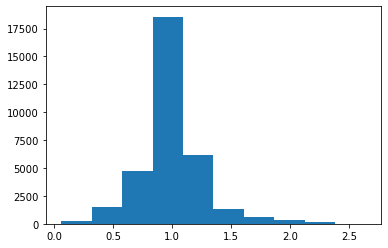

Fit a Gaussian with guess (A0, m0, s0) = (29.0, 1, 0.17713239097136863)


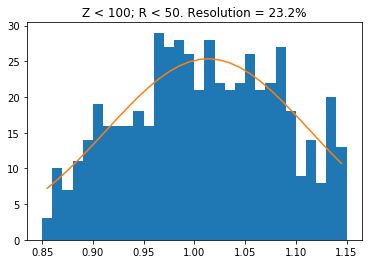

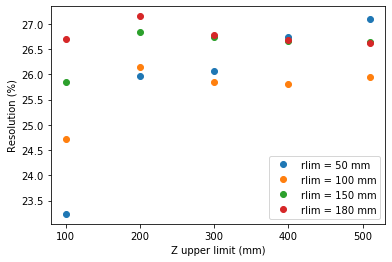

Innermost resolution =  23.24 %
Outermost resolution =  26.62 %
All resolutions: {100050: 23.23593892310144, 100100: 24.718659574227985, 100150: 25.856501665721996, 100180: 26.6933810979234, 200050: 25.959801337962045, 200100: 26.146073153381906, 200150: 26.83031120899808, 200180: 27.148567869729288, 300050: 26.06052433507735, 300100: 25.843418682136395, 300150: 26.730272625580636, 300180: 26.780777266290293, 400050: 26.74422247154723, 400100: 25.809697934348797, 400150: 26.66690106407832, 400180: 26.676070992932775, 510050: 27.087881690556596, 510100: 25.951292744271115, 510150: 26.63916905301481, 510180: 26.618630049845205}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 79.5 , 1310.8
Selected percentage = 2.5 \%


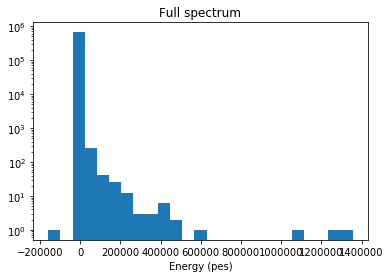

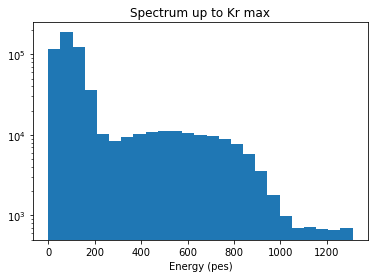

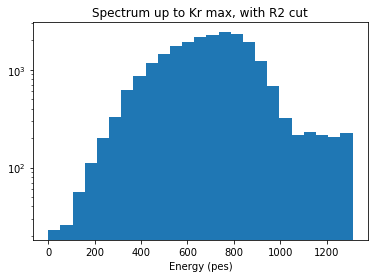

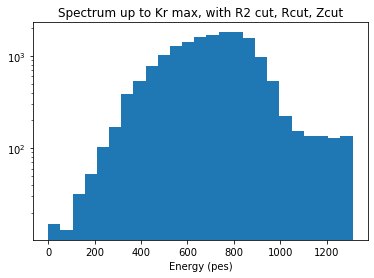

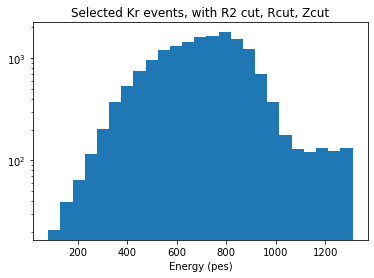

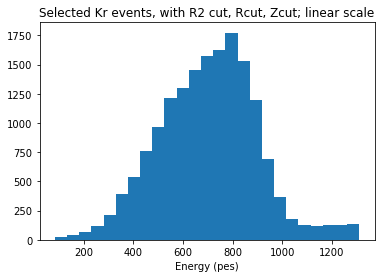

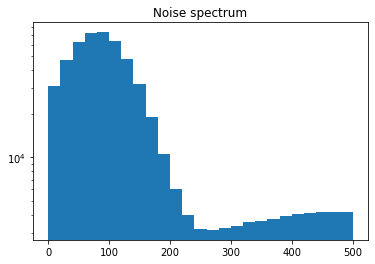

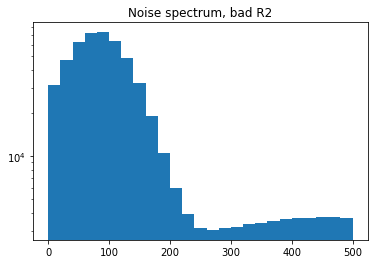

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


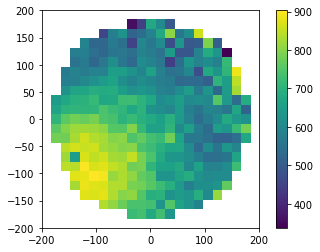

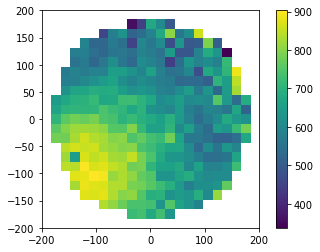

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 19.6
200000 / 549170
Est remaining = 14.2
300000 / 549170
Est remaining = 10.5
400000 / 549170
Est remaining = 6.2
500000 / 549170
Est remaining = 2.1


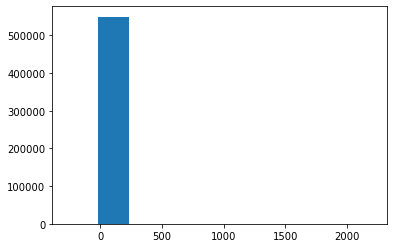

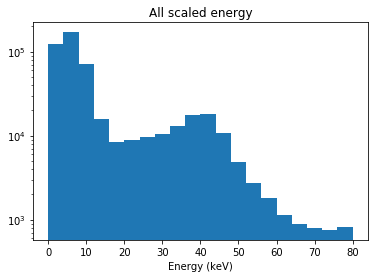

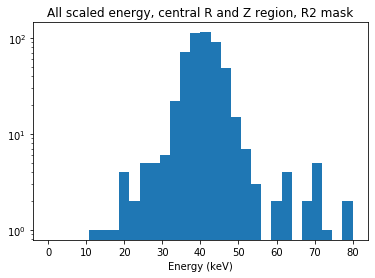

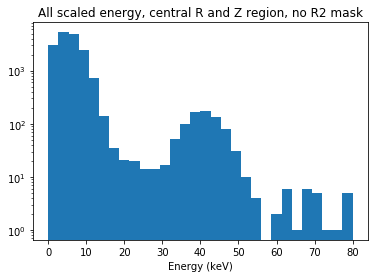

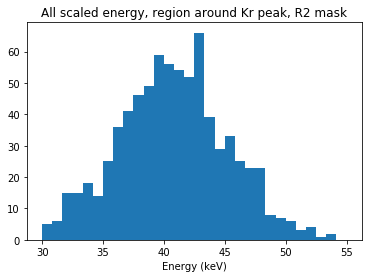

Correcting energies...
0 / 16652


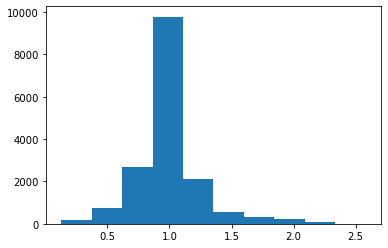

Fit a Gaussian with guess (A0, m0, s0) = (26.0, 1, 0.16909671561392192)


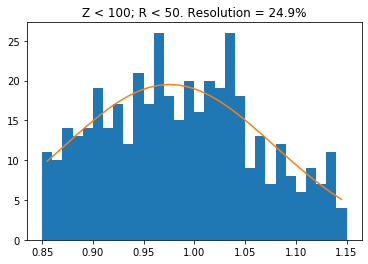

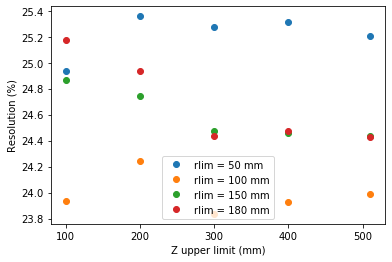

Innermost resolution =  24.93 %
Outermost resolution =  24.43 %
All resolutions: {100050: 24.932325852001505, 100100: 23.935011649231587, 100150: 24.864015851563423, 100180: 25.17161190341357, 200050: 25.357329873804684, 200100: 24.2431253409474, 200150: 24.746321756653096, 200180: 24.937473418551832, 300050: 25.271509783167428, 300100: 23.835693653567603, 300150: 24.472015433601154, 300180: 24.43755112190073, 400050: 25.313550431875324, 400100: 23.93125402690311, 400150: 24.46004904768671, 400180: 24.47757708949326, 510050: 25.202934858158095, 510100: 23.991378757779064, 510150: 24.438318592680602, 510180: 24.427935981147705}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

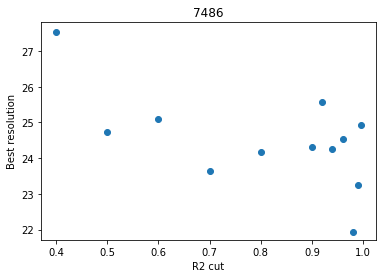

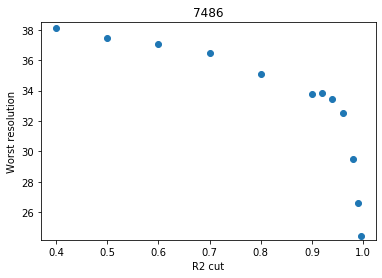

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = -124.6 , 1274.1
Selected percentage = 10.5 \%


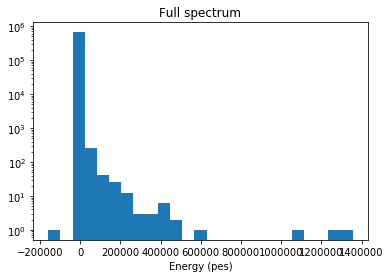

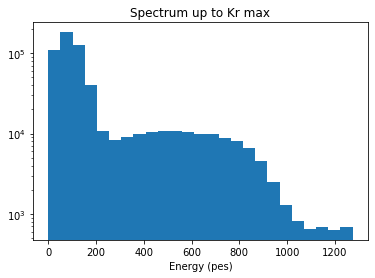

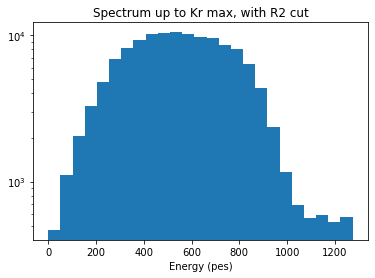

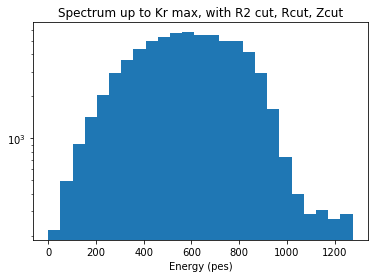

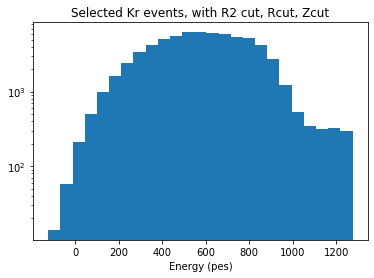

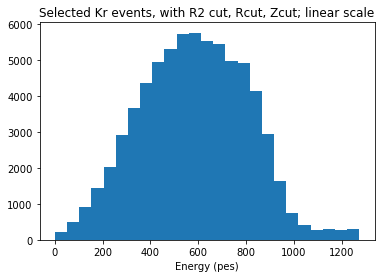

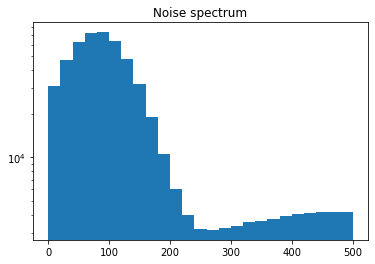

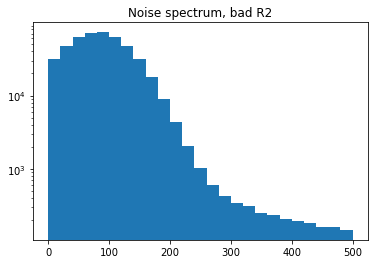

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


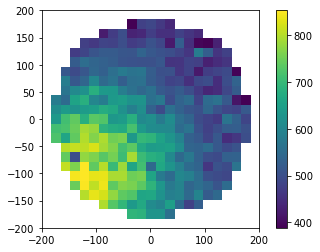

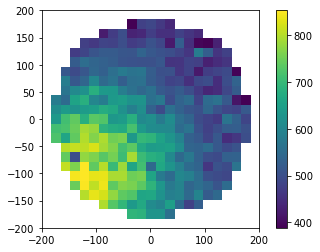

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 18.6
200000 / 549170
Est remaining = 13.6
300000 / 549170
Est remaining = 9.2
400000 / 549170
Est remaining = 5.7
500000 / 549170
Est remaining = 1.8


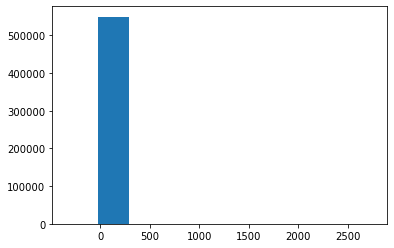

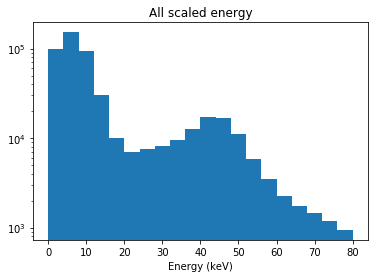

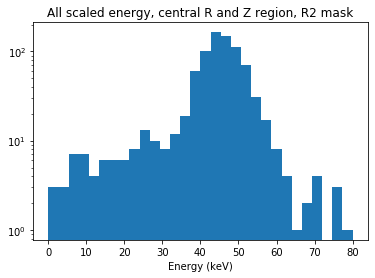

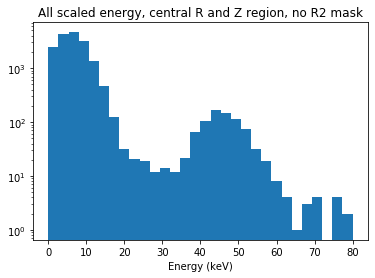

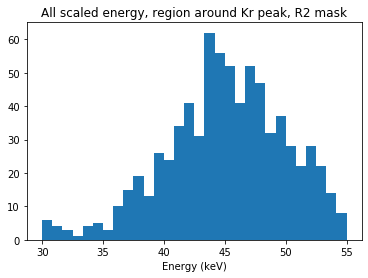

Correcting energies...
0 / 69529


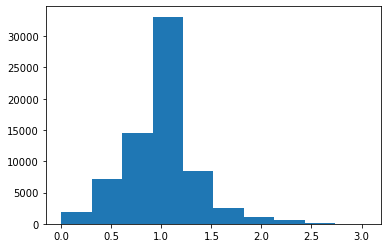

Fit a Gaussian with guess (A0, m0, s0) = (35.0, 1, 0.24206718066436092)


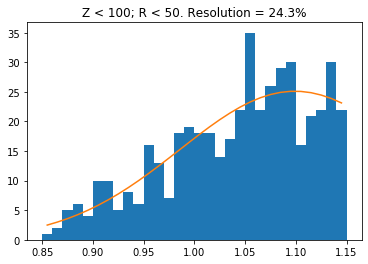

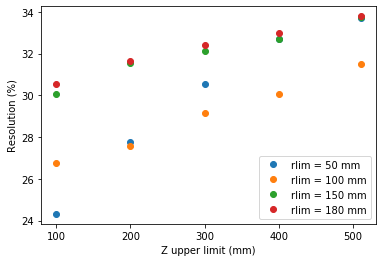

Innermost resolution =  24.32 %
Outermost resolution =  33.79 %
All resolutions: {100050: 24.321522957097216, 100100: 26.74569594149268, 100150: 30.04307683475492, 100180: 30.541853332370277, 200050: 27.74281170332689, 200100: 27.592005690549875, 200150: 31.53088857505414, 200180: 31.65505072997932, 300050: 30.53657341080637, 300100: 29.140078841983883, 300150: 32.12091555156085, 300180: 32.40116340880371, 400050: 32.719094011017944, 400100: 30.067625783004434, 400150: 32.71806487656898, 400180: 32.9753867837826, 510050: 33.68310086456658, 510100: 31.494489209748213, 510150: 33.75812082335451, 510180: 33.789779828398196}
Peak range = -121.2 , 1294.2
Selected percentage = 10.5 \%


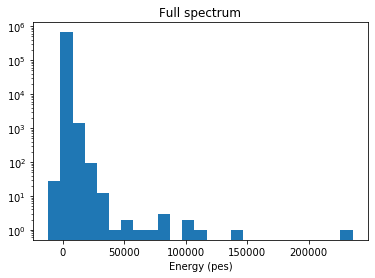

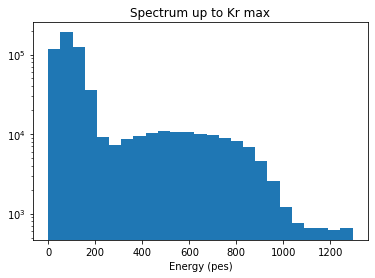

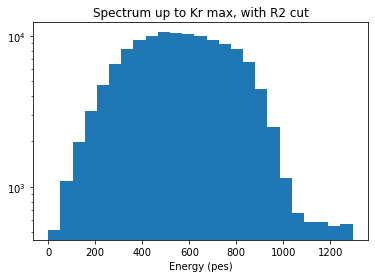

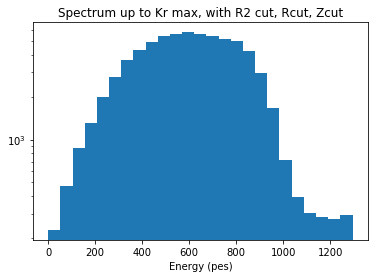

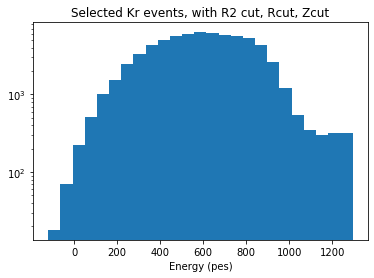

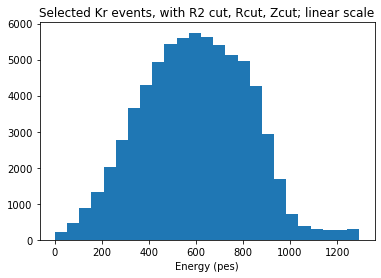

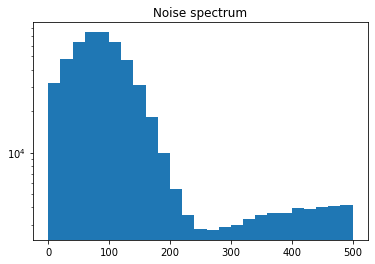

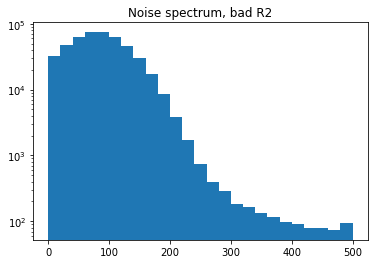

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


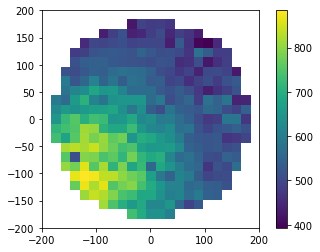

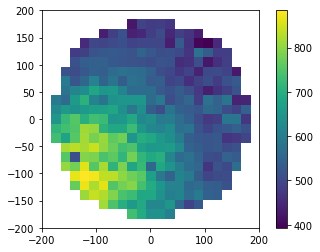

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 10.7
200000 / 549170
Est remaining = 8.2
300000 / 549170
Est remaining = 5.9
400000 / 549170
Est remaining = 3.5
500000 / 549170
Est remaining = 1.2


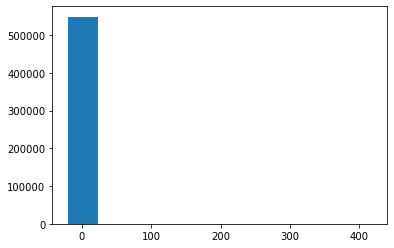

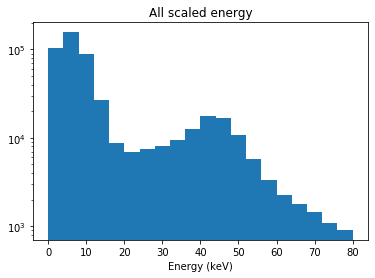

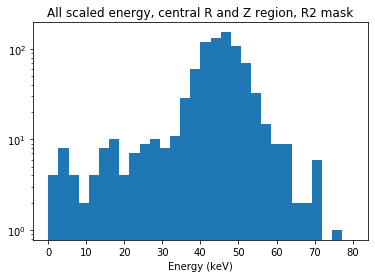

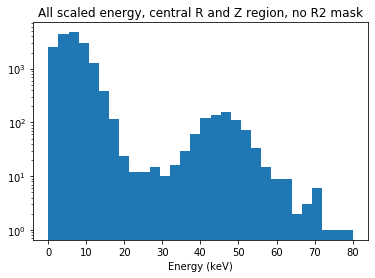

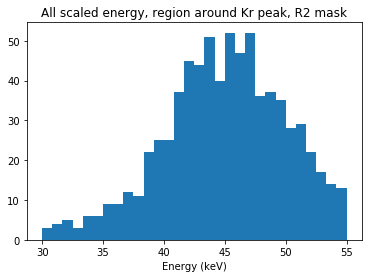

Correcting energies...
0 / 69634


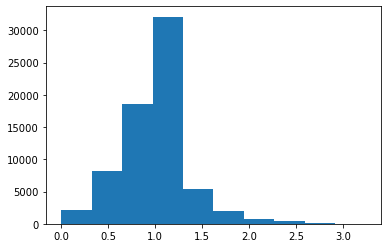

Fit a Gaussian with guess (A0, m0, s0) = (30.0, 1, 0.24094542062223293)


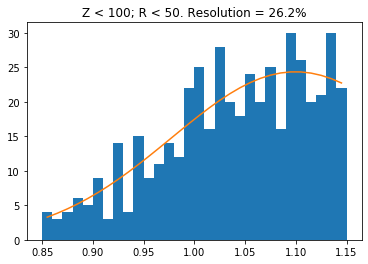

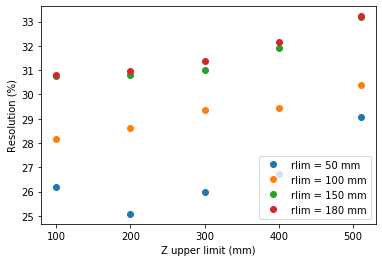

Innermost resolution =  26.17 %
Outermost resolution =  33.22 %
All resolutions: {100050: 26.168456225395786, 100100: 28.170873231844666, 100150: 30.753304876643725, 100180: 30.7931580674242, 200050: 25.080001329682755, 200100: 28.61627680634306, 200150: 30.77946058709967, 200180: 30.978401127150992, 300050: 25.9908462331911, 300100: 29.338242596280885, 300150: 31.002803322845768, 300180: 31.36507047359195, 400050: 26.73793662278974, 400100: 29.447149806016007, 400150: 31.891298830183295, 400180: 32.161471412859775, 510050: 29.065044219528474, 510100: 30.384274761960253, 510150: 33.205255814783875, 510180: 33.21664702264417}
Peak range = -121.2 , 1294.2
Selected percentage = 10.5 \%


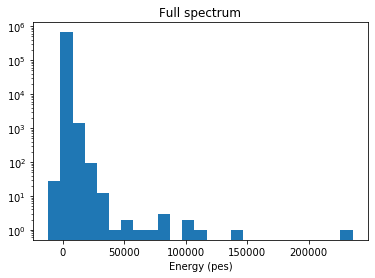

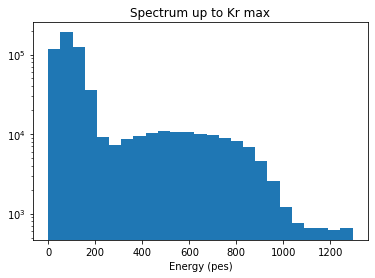

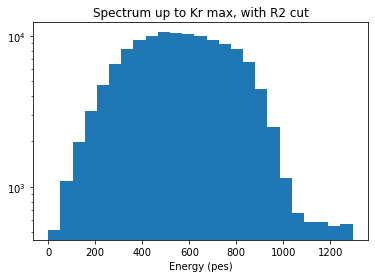

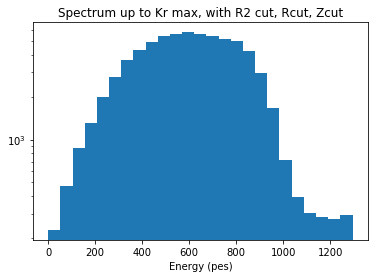

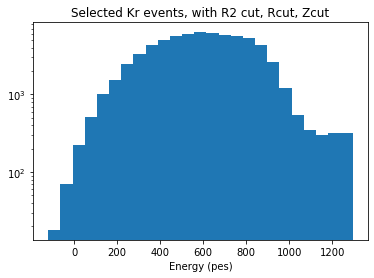

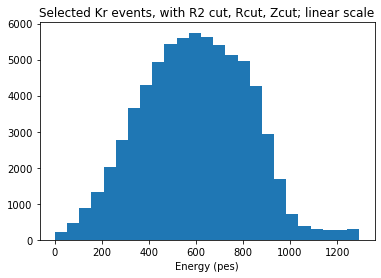

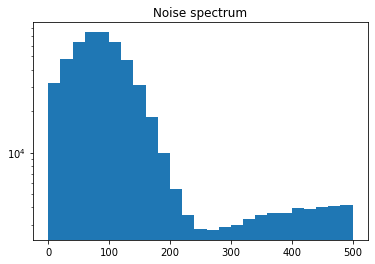

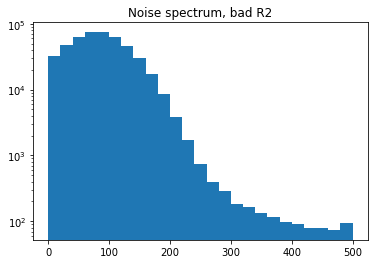

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


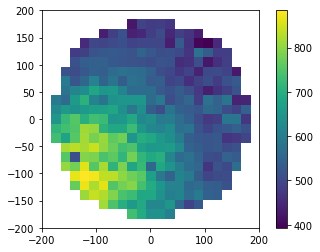

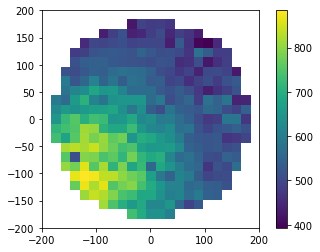

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 11.6
200000 / 549170
Est remaining = 9.0
300000 / 549170
Est remaining = 6.4
400000 / 549170
Est remaining = 3.7
500000 / 549170
Est remaining = 1.2


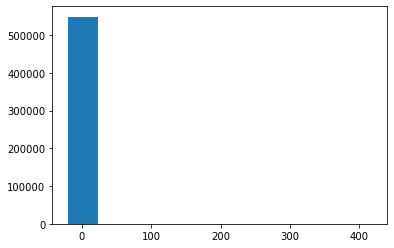

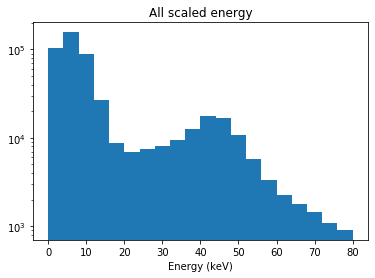

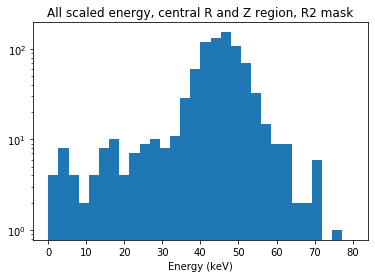

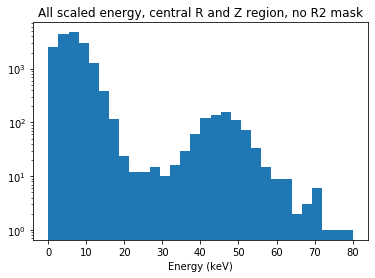

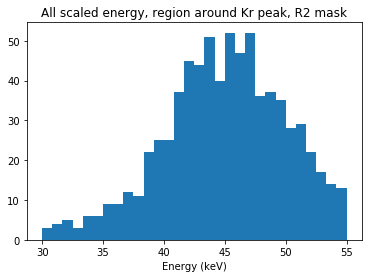

Correcting energies...
0 / 69634


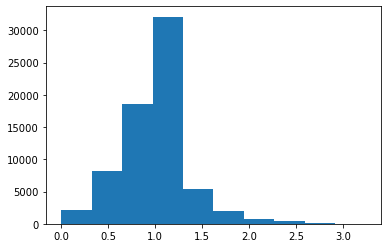

Fit a Gaussian with guess (A0, m0, s0) = (30.0, 1, 0.24094542062223293)


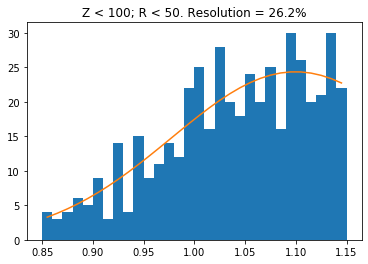

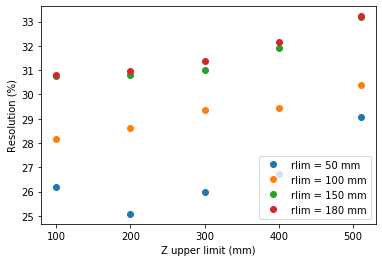

Innermost resolution =  26.17 %
Outermost resolution =  33.22 %
All resolutions: {100050: 26.168456225395786, 100100: 28.170873231844666, 100150: 30.753304876643725, 100180: 30.7931580674242, 200050: 25.080001329682755, 200100: 28.61627680634306, 200150: 30.77946058709967, 200180: 30.978401127150992, 300050: 25.9908462331911, 300100: 29.338242596280885, 300150: 31.002803322845768, 300180: 31.36507047359195, 400050: 26.73793662278974, 400100: 29.447149806016007, 400150: 31.891298830183295, 400180: 32.161471412859775, 510050: 29.065044219528474, 510100: 30.384274761960253, 510150: 33.205255814783875, 510180: 33.21664702264417}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
24.32 , 26.17 , 26.17
Outer res for pre, post, avg:
33.79 , 33.22 , 33.22


Peak range = -124.6 , 1274.1
Selected percentage = 10.5 \%


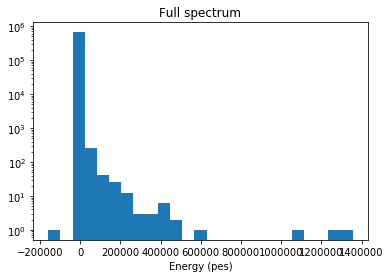

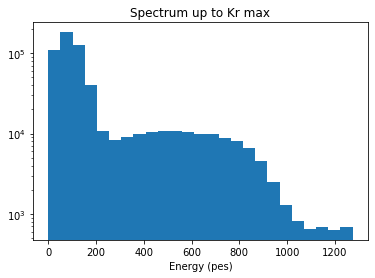

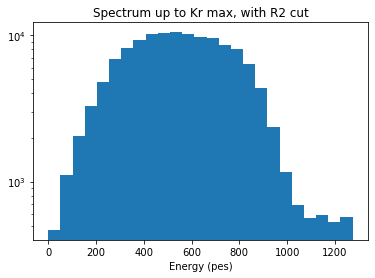

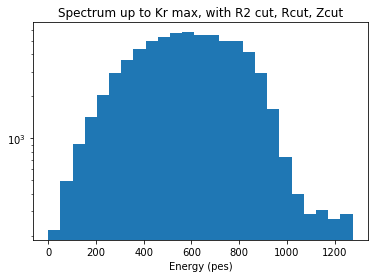

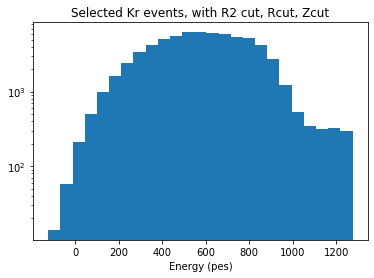

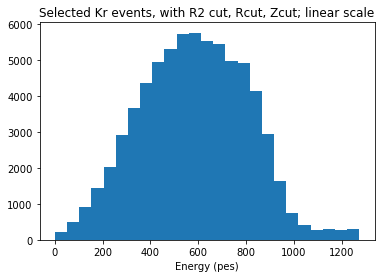

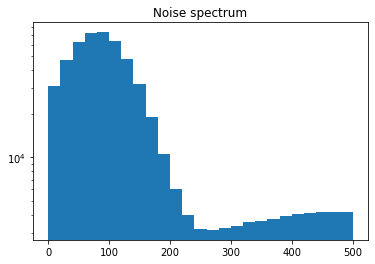

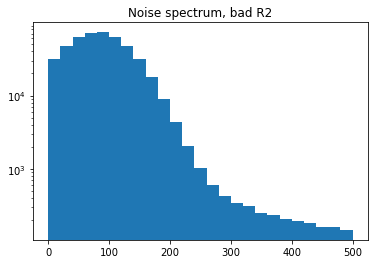

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


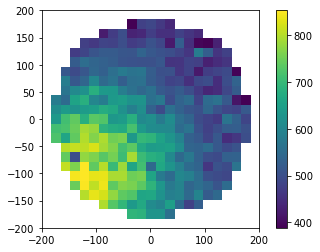

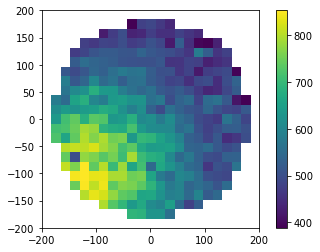

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 11.0
200000 / 549170
Est remaining = 8.4
300000 / 549170
Est remaining = 6.0
400000 / 549170
Est remaining = 3.7
500000 / 549170
Est remaining = 1.2


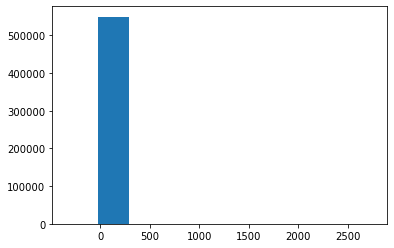

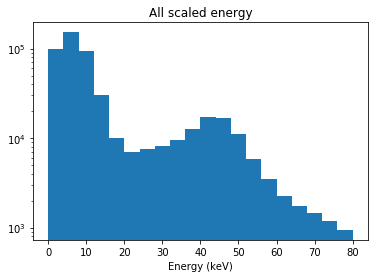

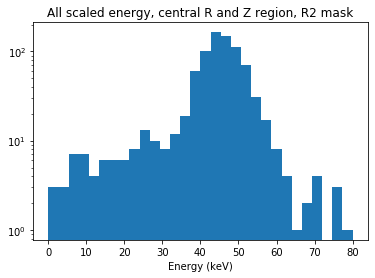

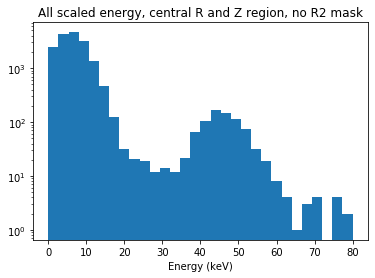

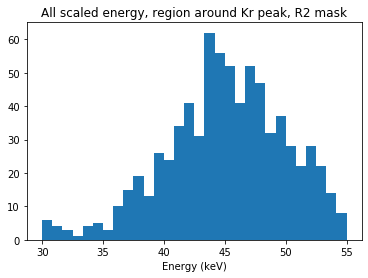

Correcting energies...
0 / 69529


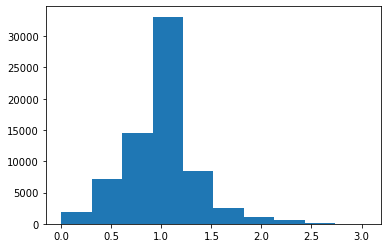

Fit a Gaussian with guess (A0, m0, s0) = (35.0, 1, 0.24206718066436092)


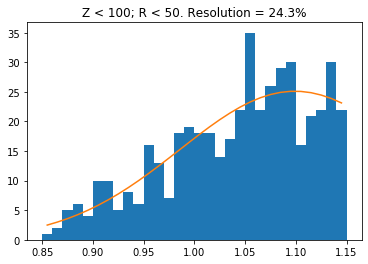

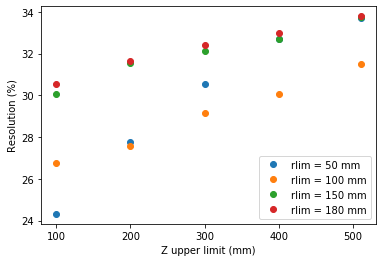

Innermost resolution =  24.32 %
Outermost resolution =  33.79 %
All resolutions: {100050: 24.321522957097216, 100100: 26.74569594149268, 100150: 30.04307683475492, 100180: 30.541853332370277, 200050: 27.74281170332689, 200100: 27.592005690549875, 200150: 31.53088857505414, 200180: 31.65505072997932, 300050: 30.53657341080637, 300100: 29.140078841983883, 300150: 32.12091555156085, 300180: 32.40116340880371, 400050: 32.719094011017944, 400100: 30.067625783004434, 400150: 32.71806487656898, 400180: 32.9753867837826, 510050: 33.68310086456658, 510100: 31.494489209748213, 510150: 33.75812082335451, 510180: 33.789779828398196}
Peak range = -117.5 , 1266.1
Selected percentage = 8.8 \%


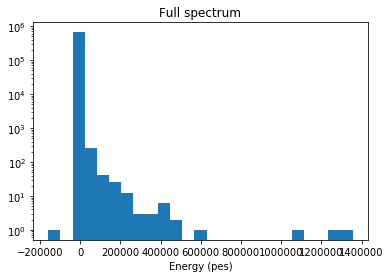

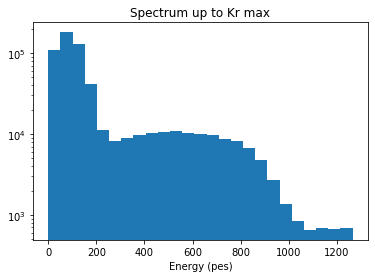

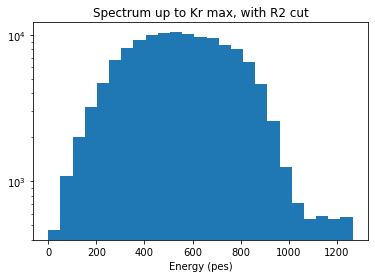

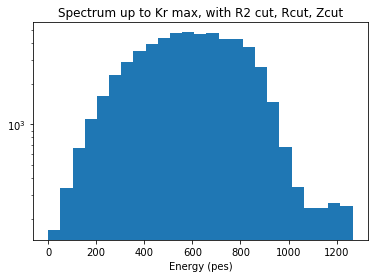

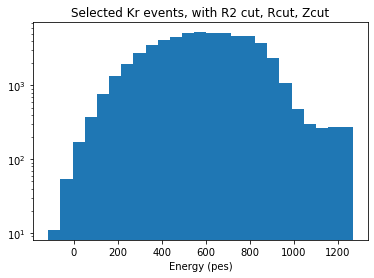

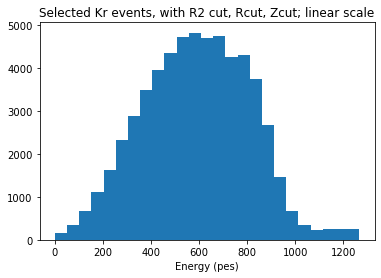

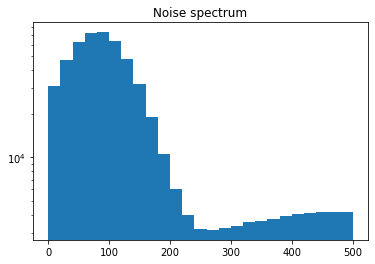

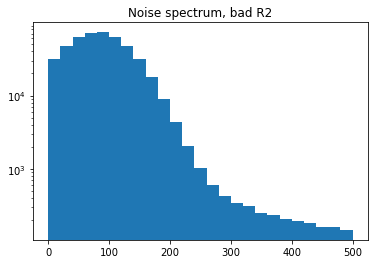

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


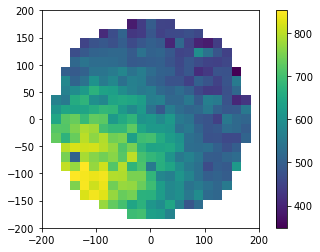

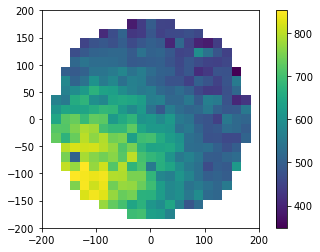

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 10.6
200000 / 549170
Est remaining = 8.0
300000 / 549170
Est remaining = 6.0
400000 / 549170
Est remaining = 3.5
500000 / 549170
Est remaining = 1.2


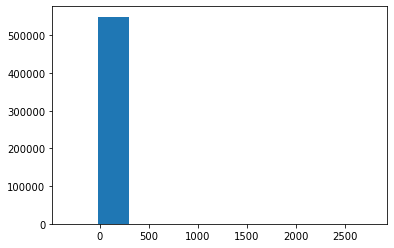

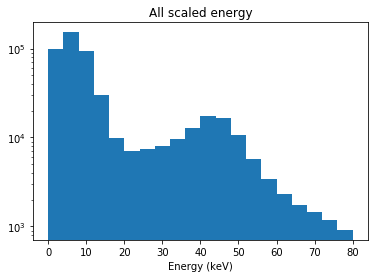

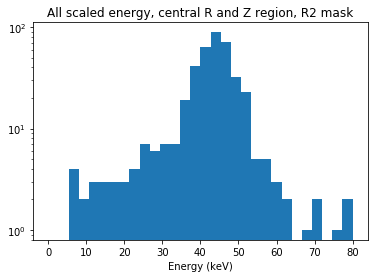

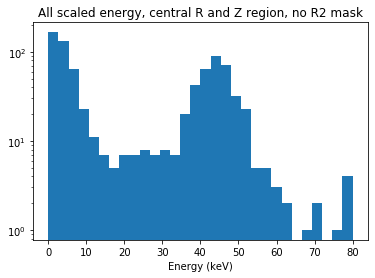

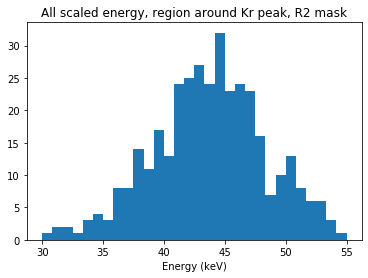

Correcting energies...
0 / 58372


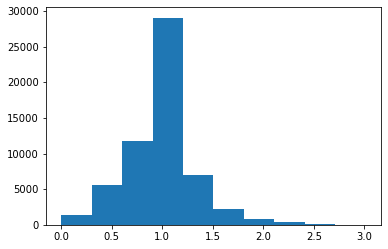

Fit a Gaussian with guess (A0, m0, s0) = (17.0, 1, 0.23887200791019908)


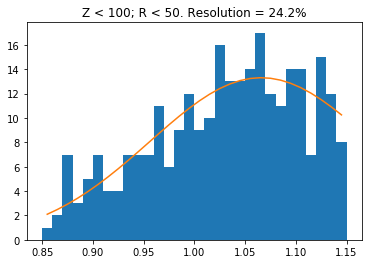

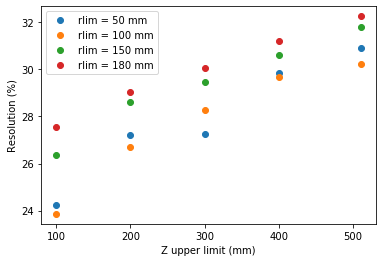

Innermost resolution =  24.23 %
Outermost resolution =  32.26 %
All resolutions: {100050: 24.232381138275787, 100100: 23.859802261858288, 100150: 26.367935177830958, 100180: 27.565514939773273, 200050: 27.211448571821656, 200100: 26.720734426336456, 200150: 28.62601108804432, 200180: 29.031670324066617, 300050: 27.25140891932385, 300100: 28.280881904944874, 300150: 29.448459276369608, 300180: 30.066494455013025, 400050: 29.85904603404792, 400100: 29.67710402415177, 400150: 30.605536751200592, 400180: 31.193476373860186, 510050: 30.898900853316306, 510100: 30.24272433118387, 510150: 31.798704409511522, 510180: 32.25764746516833}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
24.23 , 24.32
Outer res for rms, gauss:
32.26 , 33.79


Peak range = -124.6 , 1274.1
Selected percentage = 10.5 \%


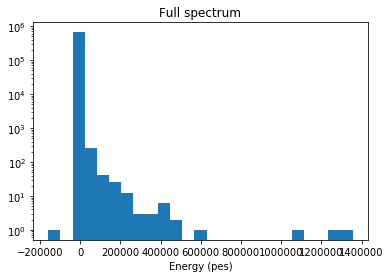

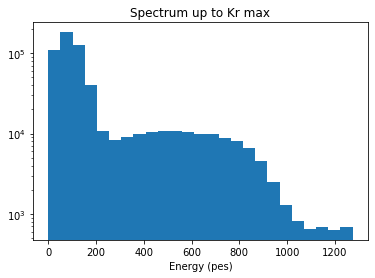

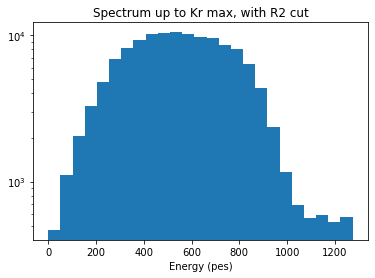

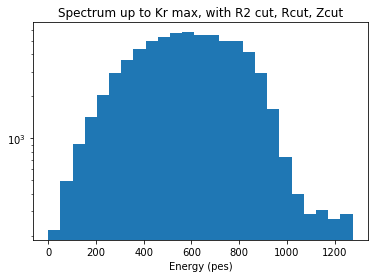

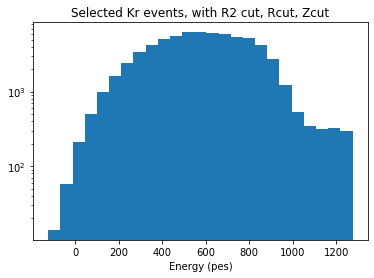

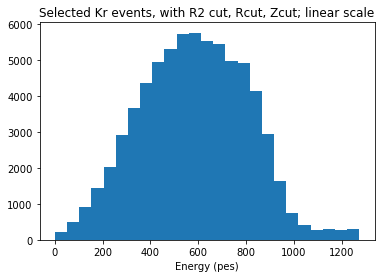

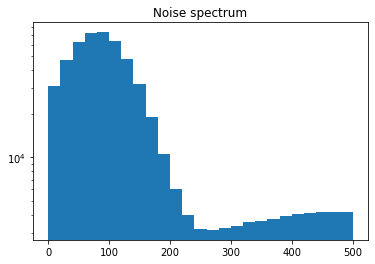

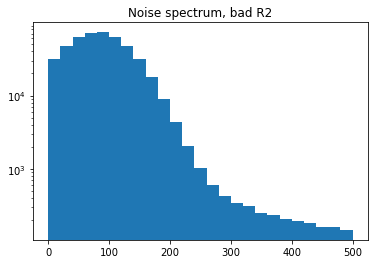

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


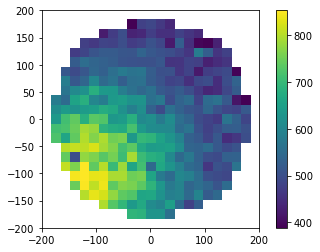

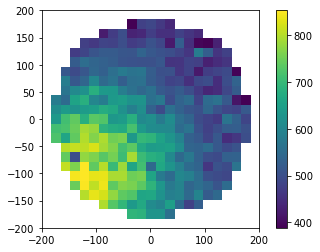

Correcting energies...
0 / 549170
100000 / 549170
Est remaining = 10.7
200000 / 549170
Est remaining = 8.2
300000 / 549170
Est remaining = 5.8
400000 / 549170
Est remaining = 3.5
500000 / 549170
Est remaining = 1.1


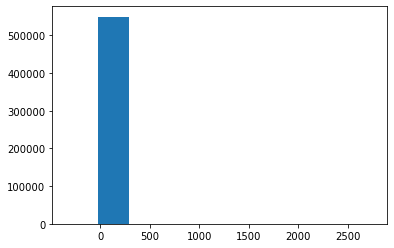

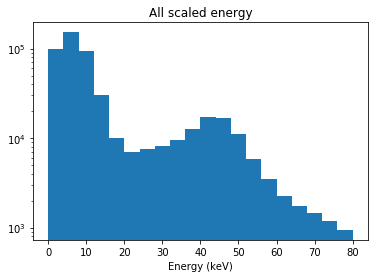

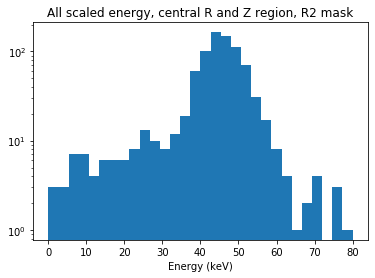

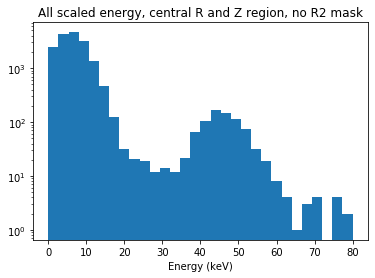

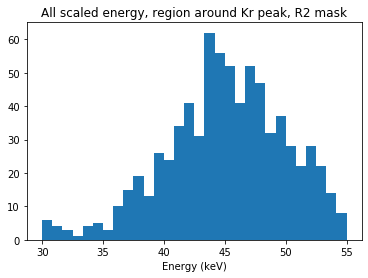

Correcting energies...
0 / 69529


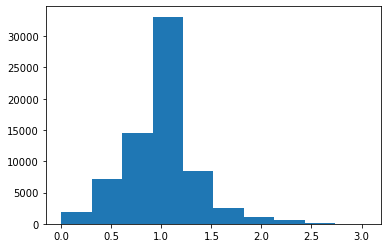

Fit a Gaussian with guess (A0, m0, s0) = (35.0, 1, 0.24206718066436092)


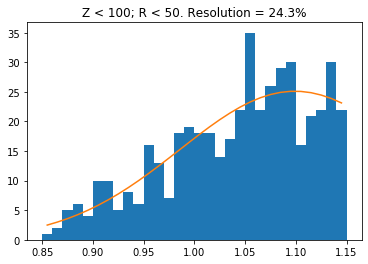

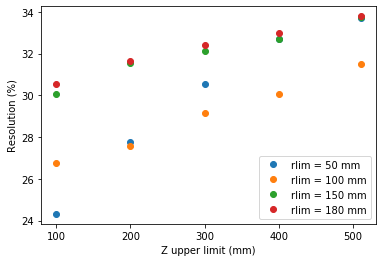

Innermost resolution =  24.32 %
Outermost resolution =  33.79 %
All resolutions: {100050: 24.321522957097216, 100100: 26.74569594149268, 100150: 30.04307683475492, 100180: 30.541853332370277, 200050: 27.74281170332689, 200100: 27.592005690549875, 200150: 31.53088857505414, 200180: 31.65505072997932, 300050: 30.53657341080637, 300100: 29.140078841983883, 300150: 32.12091555156085, 300180: 32.40116340880371, 400050: 32.719094011017944, 400100: 30.067625783004434, 400150: 32.71806487656898, 400180: 32.9753867837826, 510050: 33.68310086456658, 510100: 31.494489209748213, 510150: 33.75812082335451, 510180: 33.789779828398196}


{100050: 24.321522957097216,
 100100: 26.74569594149268,
 100150: 30.04307683475492,
 100180: 30.541853332370277,
 200050: 27.74281170332689,
 200100: 27.592005690549875,
 200150: 31.53088857505414,
 200180: 31.65505072997932,
 300050: 30.53657341080637,
 300100: 29.140078841983883,
 300150: 32.12091555156085,
 300180: 32.40116340880371,
 400050: 32.719094011017944,
 400100: 30.067625783004434,
 400150: 32.71806487656898,
 400180: 32.9753867837826,
 510050: 33.68310086456658,
 510100: 31.494489209748213,
 510150: 33.75812082335451,
 510180: 33.789779828398196}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 19.5 minutes
